In [26]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os

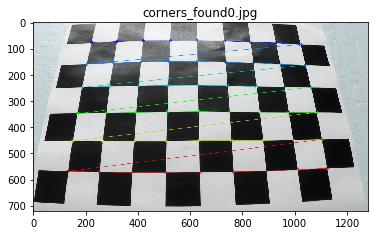

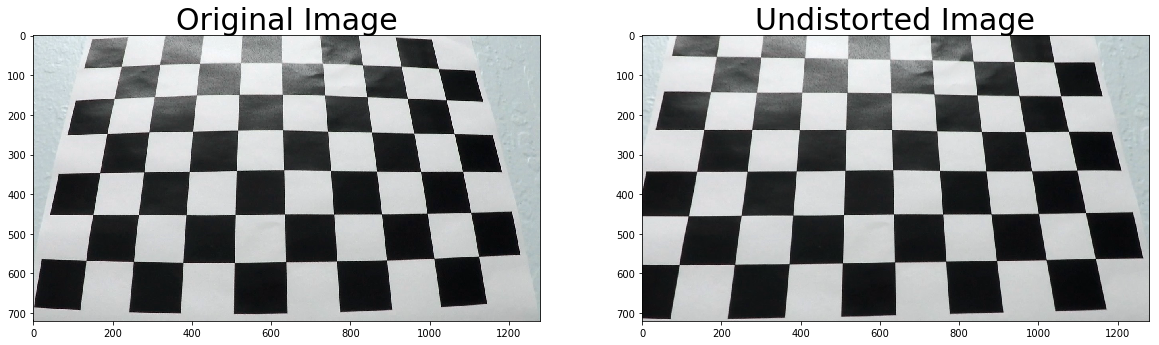

In [12]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration3.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images[0:1]):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    #print(fname + str(ret))
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        plt.title(write_name)
        plt.imshow(img)
        cv2.waitKey(500)


# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('./camera_cal/calibration2_undist.jpg',dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [14]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #print(ret)
    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

True


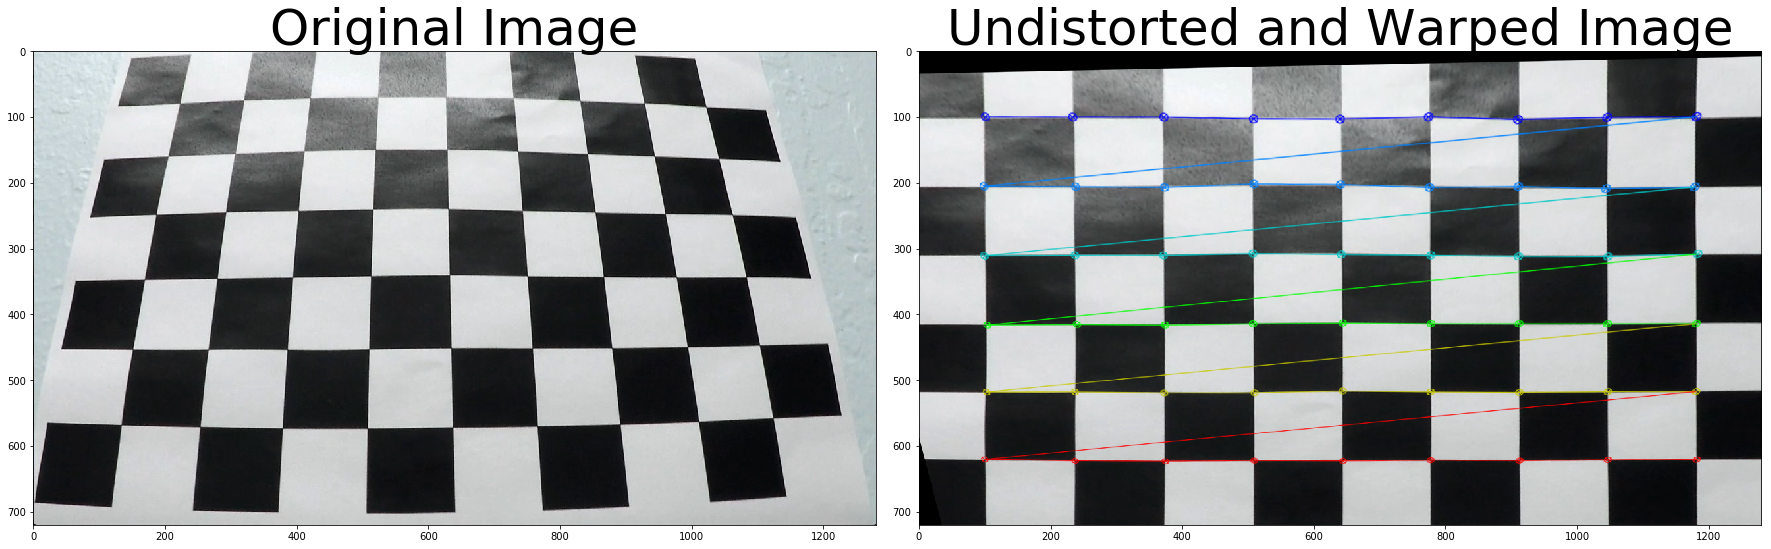

In [13]:
img = cv2.imread('./camera_cal/calibration3.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
img_size = (img.shape[1], img.shape[0])
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [15]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


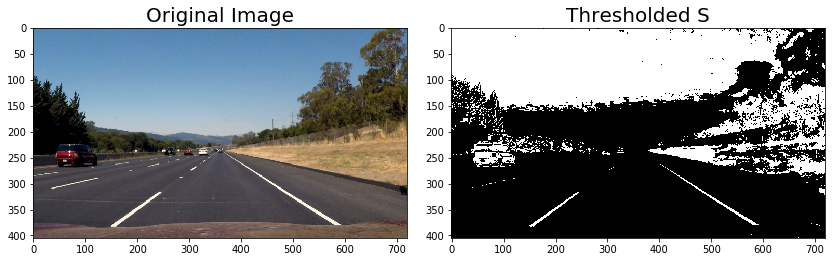

In [55]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Read in an image
image = mpimg.imread('test_images/straight_lines2.jpg')
image = cv2.resize(image,(720,405))


hls_binary = hls_select(image, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

test_images/straight_lines1.jpg
test_images/straight_lines2.jpg
test_images/test1.jpg
test_images/test2.jpg
test_images/test3.jpg
test_images/test4.jpg
test_images/test5.jpg


/Users/govindaputhalapat/anaconda/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


test_images/test6.jpg


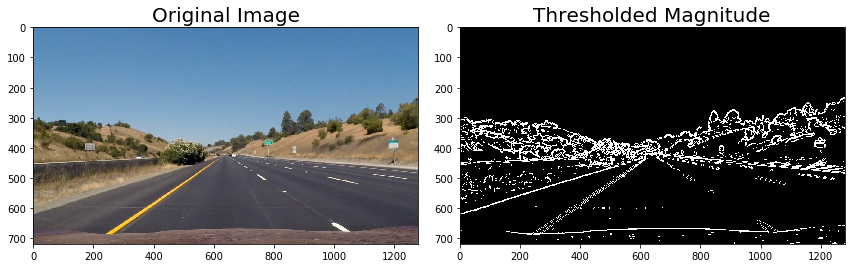

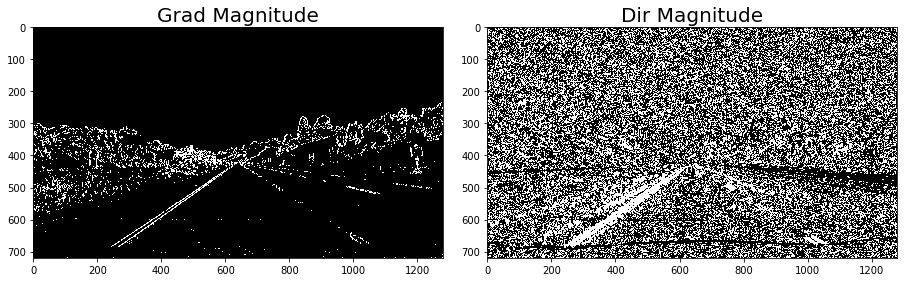

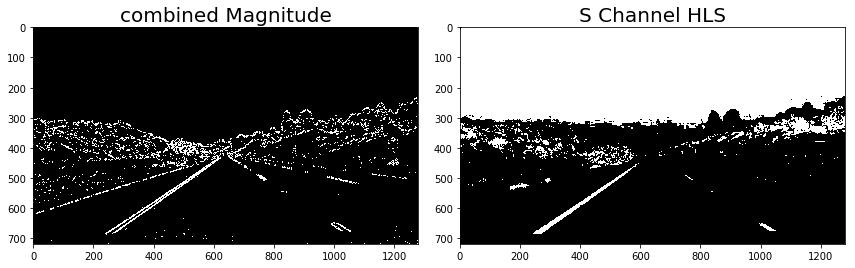

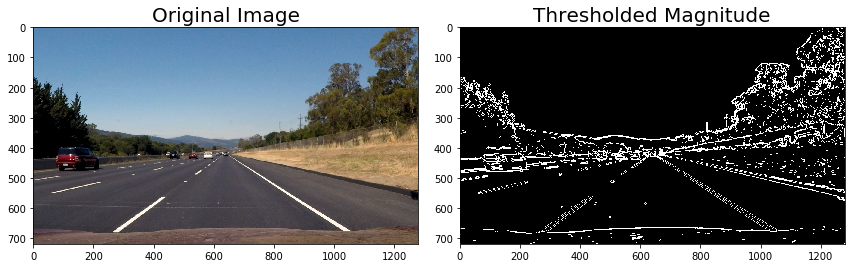

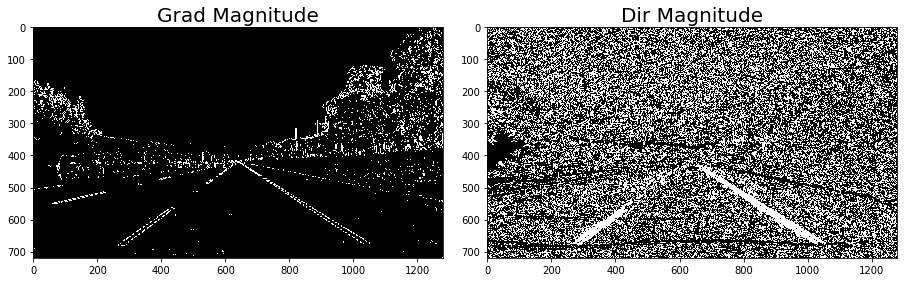

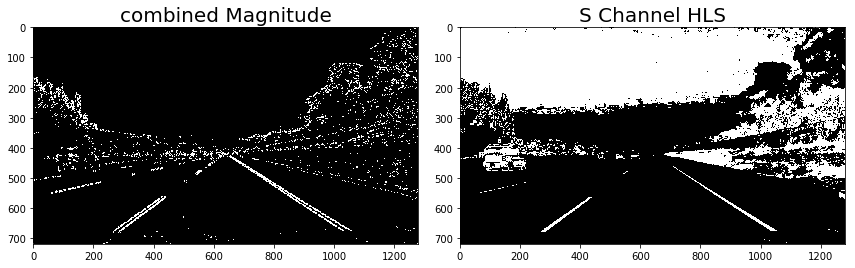

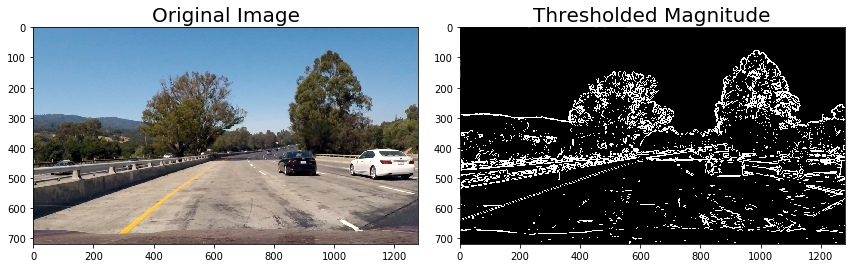

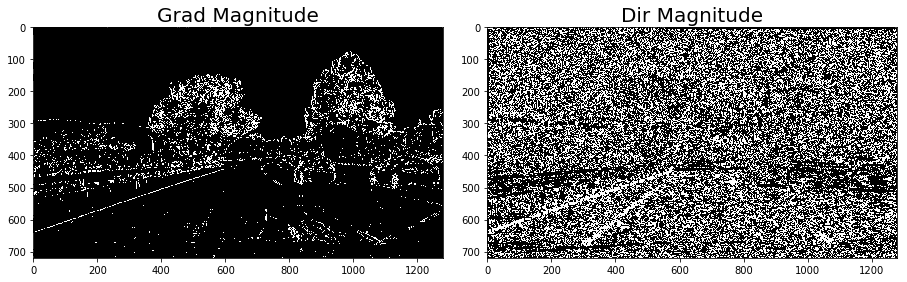

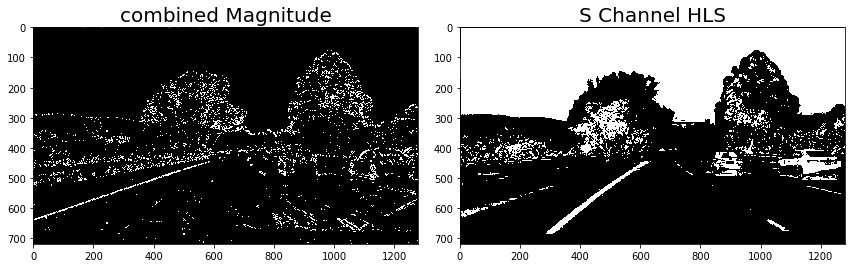

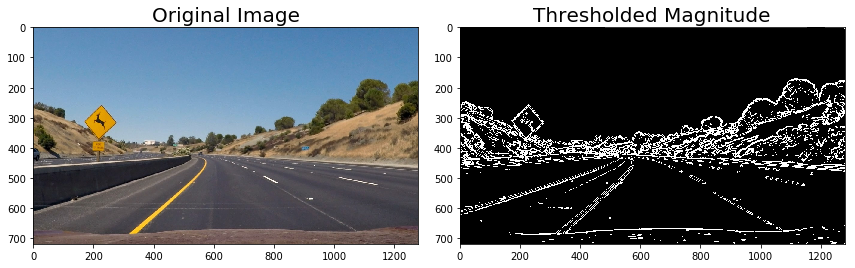

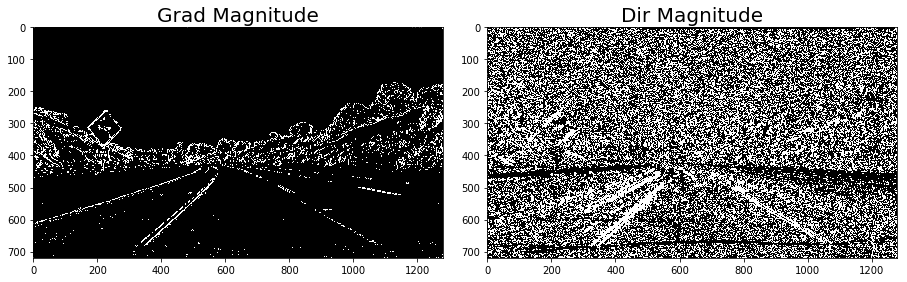

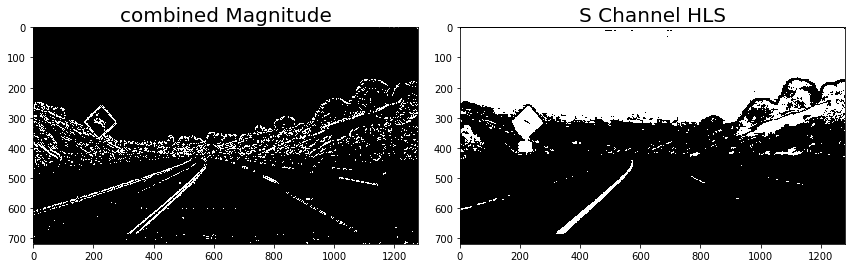

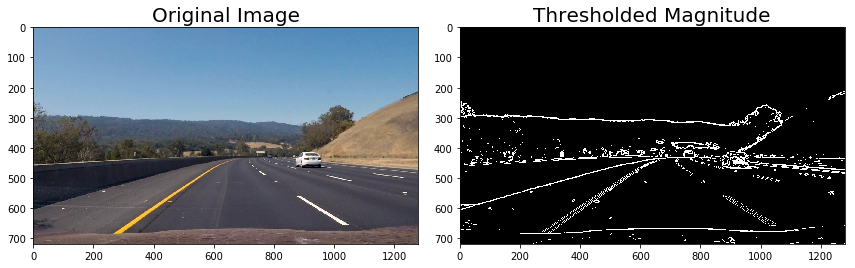

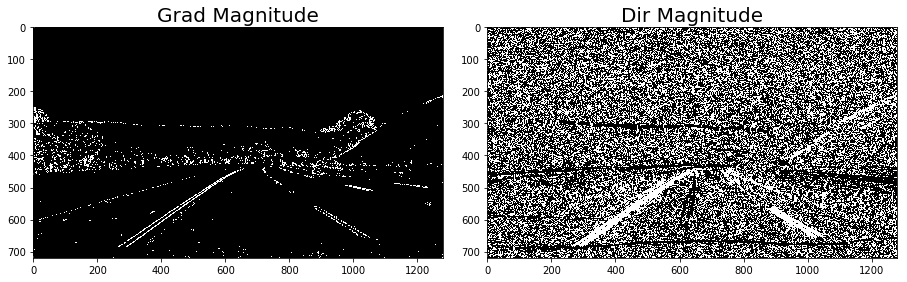

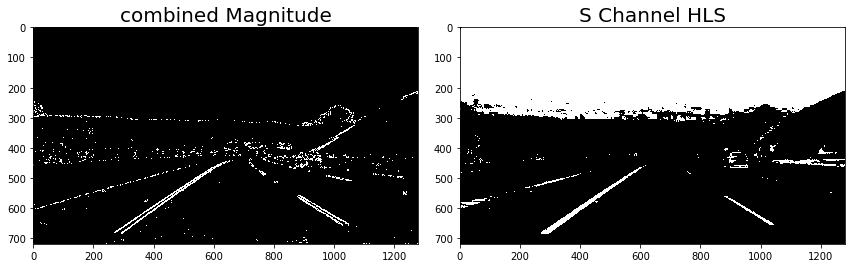

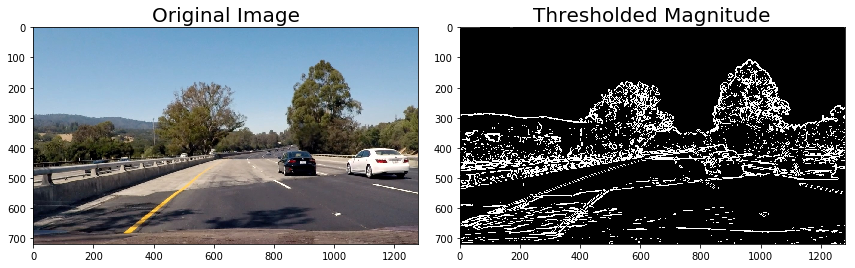

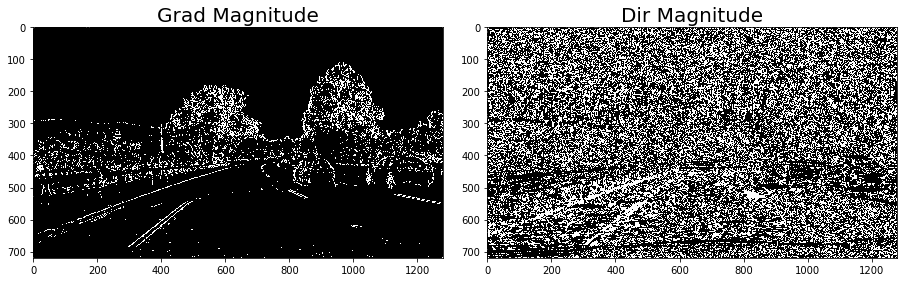

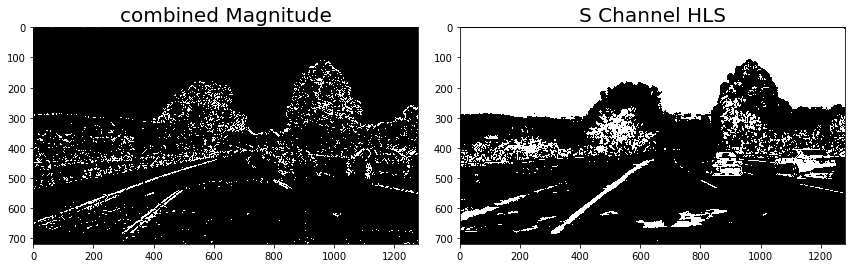

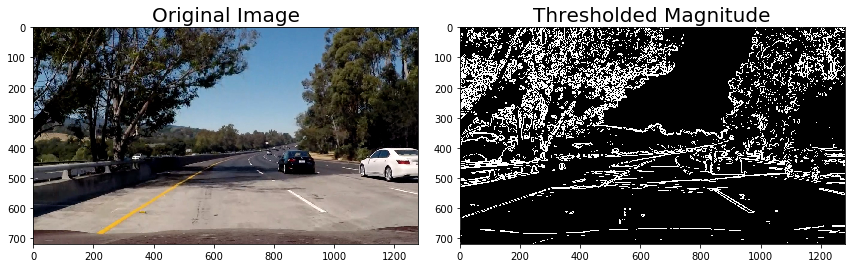

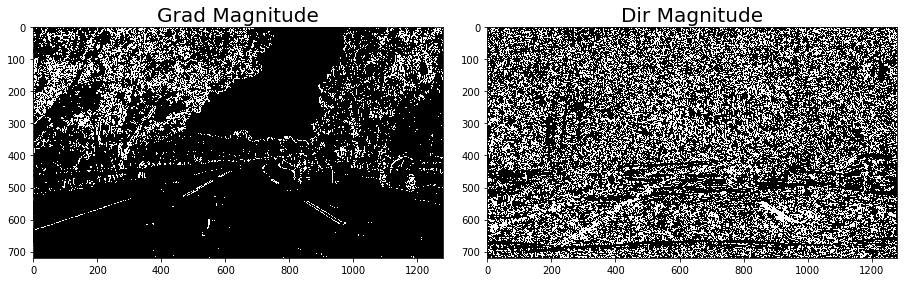

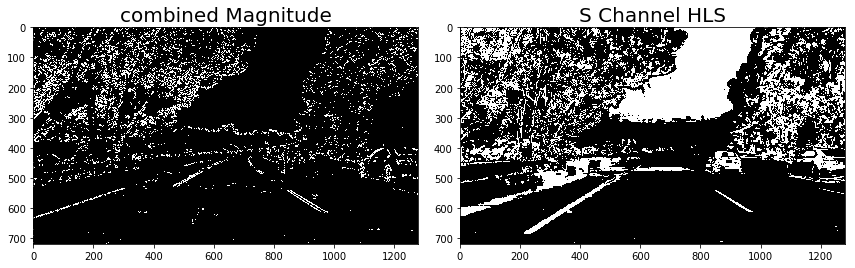

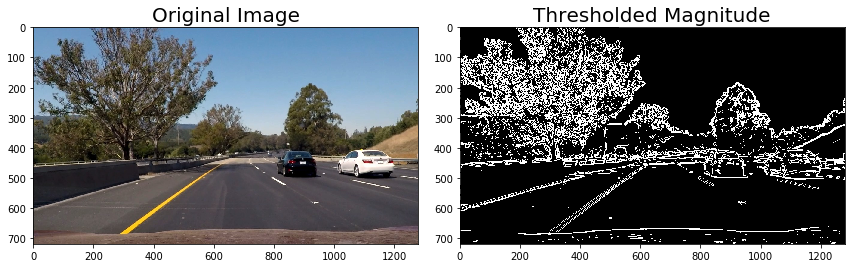

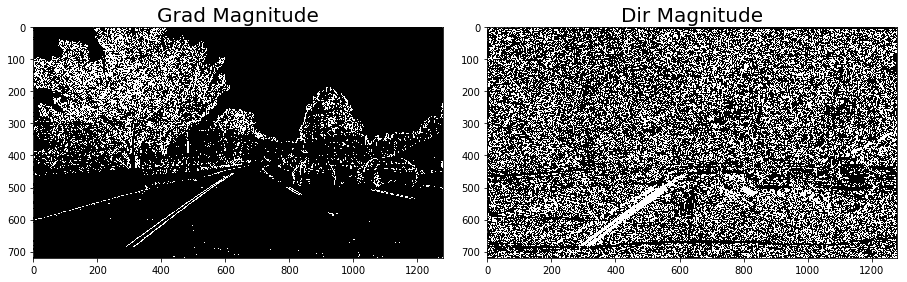

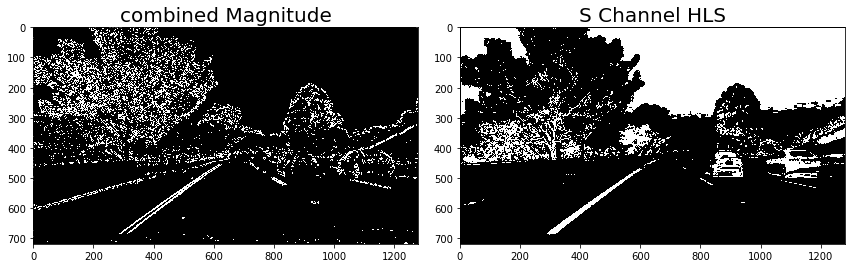

In [78]:
images = os.listdir('./test_images')  
for fname in images:
    fname = os.path.join('test_images',fname)
    image = mpimg.imread(fname)
    # Run the function
    print(fname)
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))

    # Run the function
    grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)

    # Run the function
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=255)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=255)
    #mag_binaryt = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
    #dir_binaryt = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))
    hls_binary = hls_select(image, thresh=(90, 255))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # Plot the result
    figsize=(12,5)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(mag_binary, cmap='gray')
    ax2.set_title('Thresholded Magnitude', fontsize=20)
    f, (ax3, ax4) = plt.subplots(1, 2, figsize=figsize)
    f.tight_layout()
    ax3.imshow(grad_binary, cmap='gray')
    ax3.set_title('Grad Magnitude', fontsize=20)
    ax4.imshow(dir_binary, cmap='gray')
    ax4.set_title('Dir Magnitude', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    f, (ax5, ax6) = plt.subplots(1, 2, figsize=figsize)
    f.tight_layout()
    ax5.imshow(combined, cmap='gray')
    ax5.set_title('combined Magnitude', fontsize=20)
    ax6.imshow(hls_binary, cmap='gray')
    ax6.set_title('S Channel HLS', fontsize=20)

In [94]:
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
 
def pipeline2(image):    
    # Run the function
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))

    # Run the function
    grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)

    # Run the function
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=255)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=255)

    hls_binary = hls_select(image, thresh=(90, 255))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    combined2 = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grad_binary == 1) & (hls_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined2[((hls_binary == 1) & (dir_binary ==1)) | ((combined == 1) & (dir_binary ==1)) | (grad_binary == 1)] = 1
    return combined2

In [196]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def lane_corners_unwarp(img, nx=nx, ny=ny, mtx=mtx, dist=dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    area_of_interest = [[150+430,460],[1150-440,460],[1150,720],[150,720]]
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])

    # Choose an offset from image corners to plot detected corners
    offset1 = 200 # offset for dst points x value
    offset2 = 0 # offset for dst points bottom y value
    offset3 = 0 # offset for dst points top y value
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32(area_of_interest)
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    dst = np.float32([[offset1, offset3], 
                      [img_size[0]-offset1, offset3], 
                      [img_size[0]-offset1, img_size[1]-offset2], 
                      [offset1, img_size[1]-offset2]])

    #apex, apey = 360, 258
    #offset_far = 50
    #offset_near = 10
    #src = np.float32([[int(apex-offset_far),apey],
    #                  [int(apex+offset_far),apey],
    #                  [int(0+offset_near),390],
    #                  [int(720-offset_near),390]])
    #dst = np.float32([[0,0],[720,0],[0,405],[720,405]])
    #offset = 100 # offset for dst points

    # For source points I'm grabbing the outer four detected corners
    #src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    #dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
    #                             [img_size[0]-offset, img_size[1]-offset], 
    #                             [offset, img_size[1]-offset]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv

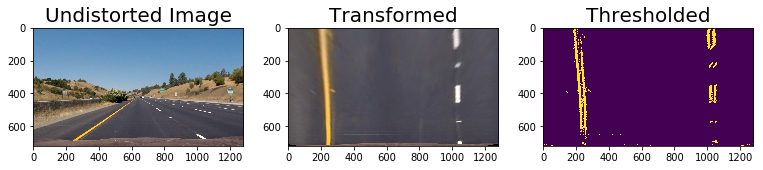

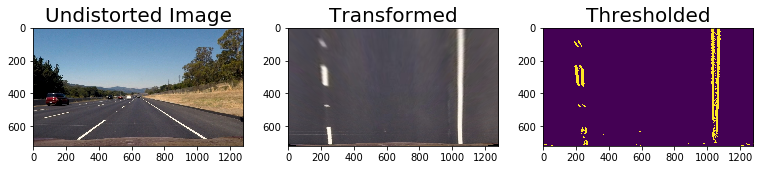

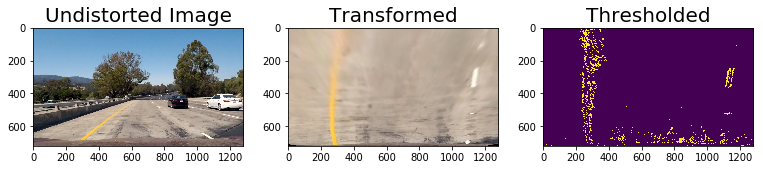

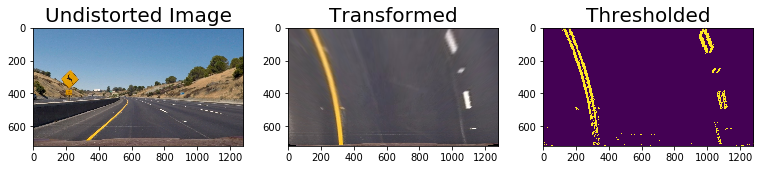

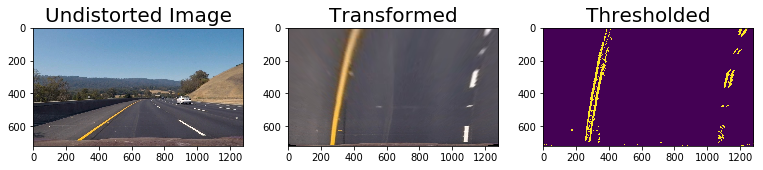

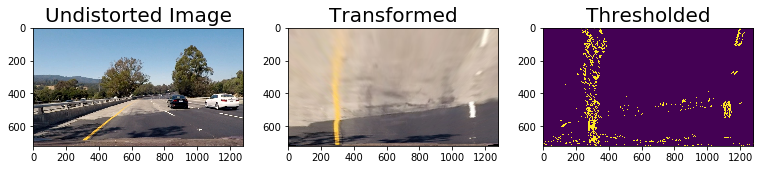

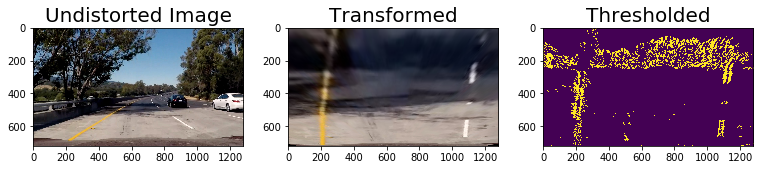

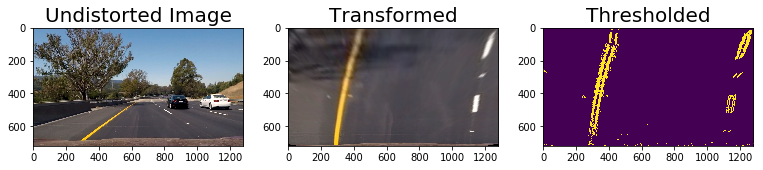

In [197]:
images = os.listdir('./test_images')  
for fname in images:
    fname = os.path.join('test_images',fname)
    img = mpimg.imread(fname)
    warped, M, Minv = lane_corners_unwarp(img)
    thresholded = pipeline2(warped)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(warped)
    ax2.set_title('Transformed', fontsize=20)
    ax3.imshow(thresholded)
    ax3.set_title('Thresholded', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [198]:
def get_lane(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    return leftx, lefty, rightx, righty

def fit_poly(image, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each
    ploty = np.linspace(0, 719, num=720)
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit,left_fitx, right_fit,right_fitx


In [207]:
def l_pipeline(img):
    warped, M,Minv = lane_corners_unwarp(img)
    thresholded = pipeline2(warped)

    leftx, lefty, rightx, righty = get_lane(thresholded)
    left_fit,left_fitx, right_fit,right_fitx = fit_poly(img, leftx, lefty, rightx, righty)
    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, 719, num=720)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    #print(ploty.shape)
    #print(left_fitx.shape)
    #print(right_fitx.shape)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    #print(pts.shape)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    str_curv = 'Radius of Curvature: Right = ' + str(np.round(right_curverad,2)) + ' m. , Left = ' 
                + str(np.round(left_curverad,2)) + ' m.'
    
    left_mean = np.mean(leftx)
    right_mean = np.mean(rightx)
    camera_pos = (combined.shape[1]/2)-np.mean([left_mean, right_mean])
    dist_offset = np.round(camera_pos*xm_per_pix,2)
    str_offset = 'Offset from center: ' + str(dist_offset) + ' m.'

    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, str_curv, (30, 60), font, 1, (0,255,0), 2)
    cv2.putText(result, str_offset, (30, 90), font, 1, (0,255,0), 2)

    
    return result

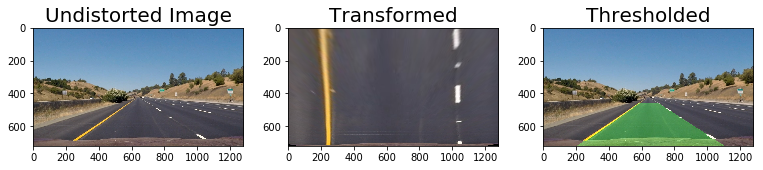

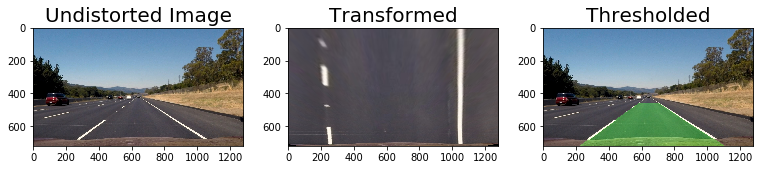

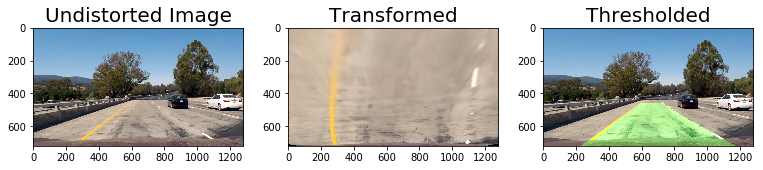

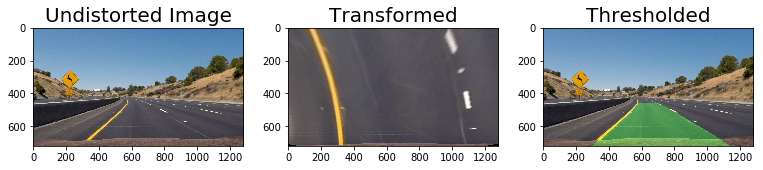

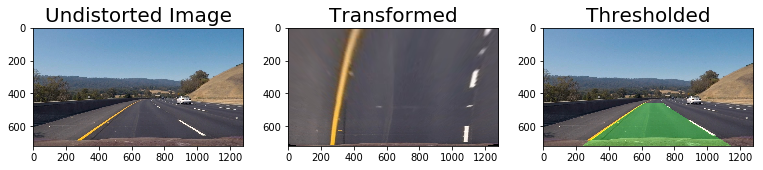

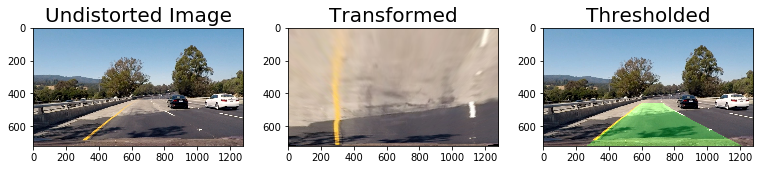

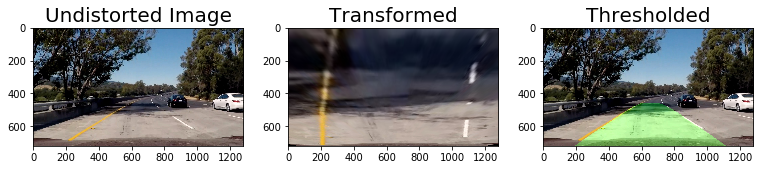

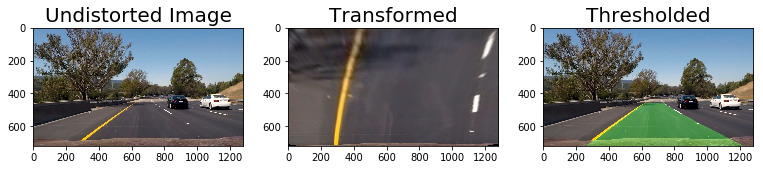

In [208]:
images = os.listdir('./test_images')  
for fname in images:
    fname = os.path.join('test_images',fname)
    img = mpimg.imread(fname)
    #img = cv2.resize(img, (720, 405))
    warped, M, Minv = lane_corners_unwarp(img)
    thresholded = pipeline2(warped)
    result = l_pipeline(img)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(warped)
    ax2.set_title('Transformed', fontsize=20)
    ax3.imshow(result)
    ax3.set_title('Thresholded', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [205]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(l_pipeline) 
%time write_clip.write_videofile(write_output, audio=False)

(1, 1440, 2)
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]  0%|          | 1/1261 [00:00<06:42,  3.13it/s]

(1, 1440, 2)


  0%|          | 2/1261 [00:00<06:43,  3.12it/s]

(1, 1440, 2)


  0%|          | 3/1261 [00:00<06:37,  3.16it/s]

(1, 1440, 2)


  0%|          | 4/1261 [00:01<06:34,  3.19it/s]

(1, 1440, 2)


  0%|          | 5/1261 [00:01<06:32,  3.20it/s]

(1, 1440, 2)


  0%|          | 6/1261 [00:01<06:31,  3.21it/s]

(1, 1440, 2)


  1%|          | 7/1261 [00:02<06:30,  3.21it/s]

(1, 1440, 2)


  1%|          | 8/1261 [00:02<06:27,  3.23it/s]

(1, 1440, 2)


  1%|          | 9/1261 [00:02<06:40,  3.12it/s]

(1, 1440, 2)


  1%|          | 10/1261 [00:03<06:39,  3.13it/s]

(1, 1440, 2)


  1%|          | 11/1261 [00:03<06:34,  3.16it/s]

(1, 1440, 2)


  1%|          | 12/1261 [00:03<06:29,  3.21it/s]

(1, 1440, 2)


  1%|          | 13/1261 [00:04<06:28,  3.21it/s]

(1, 1440, 2)


  1%|          | 14/1261 [00:04<06:28,  3.21it/s]

(1, 1440, 2)


  1%|          | 15/1261 [00:04<06:37,  3.13it/s]

(1, 1440, 2)


  1%|▏         | 16/1261 [00:05<06:32,  3.17it/s]

(1, 1440, 2)


  1%|▏         | 17/1261 [00:05<06:31,  3.17it/s]

(1, 1440, 2)


  1%|▏         | 18/1261 [00:05<06:40,  3.10it/s]

(1, 1440, 2)


  2%|▏         | 19/1261 [00:06<06:38,  3.12it/s]

(1, 1440, 2)


  2%|▏         | 20/1261 [00:06<06:36,  3.13it/s]

(1, 1440, 2)


  2%|▏         | 21/1261 [00:06<06:32,  3.16it/s]

(1, 1440, 2)


  2%|▏         | 22/1261 [00:06<06:31,  3.16it/s]

(1, 1440, 2)


  2%|▏         | 23/1261 [00:07<06:37,  3.11it/s]

(1, 1440, 2)


  2%|▏         | 24/1261 [00:07<06:33,  3.15it/s]

(1, 1440, 2)


  2%|▏         | 25/1261 [00:07<06:29,  3.17it/s]

(1, 1440, 2)


  2%|▏         | 26/1261 [00:08<06:27,  3.19it/s]

(1, 1440, 2)


  2%|▏         | 27/1261 [00:08<06:21,  3.24it/s]

(1, 1440, 2)


  2%|▏         | 28/1261 [00:08<06:19,  3.25it/s]

(1, 1440, 2)


  2%|▏         | 29/1261 [00:09<06:22,  3.22it/s]

(1, 1440, 2)


  2%|▏         | 30/1261 [00:09<06:23,  3.21it/s]

(1, 1440, 2)


  2%|▏         | 31/1261 [00:09<06:32,  3.13it/s]

(1, 1440, 2)


  3%|▎         | 32/1261 [00:10<06:29,  3.16it/s]

(1, 1440, 2)


  3%|▎         | 33/1261 [00:10<06:30,  3.15it/s]

(1, 1440, 2)


  3%|▎         | 34/1261 [00:10<06:35,  3.10it/s]

(1, 1440, 2)


  3%|▎         | 35/1261 [00:11<06:29,  3.15it/s]

(1, 1440, 2)


  3%|▎         | 36/1261 [00:11<06:25,  3.17it/s]

(1, 1440, 2)


  3%|▎         | 37/1261 [00:11<06:24,  3.18it/s]

(1, 1440, 2)


  3%|▎         | 38/1261 [00:12<06:31,  3.12it/s]

(1, 1440, 2)


  3%|▎         | 39/1261 [00:12<06:32,  3.11it/s]

(1, 1440, 2)


  3%|▎         | 40/1261 [00:12<06:34,  3.10it/s]

(1, 1440, 2)


  3%|▎         | 41/1261 [00:12<06:39,  3.06it/s]

(1, 1440, 2)


  3%|▎         | 42/1261 [00:13<06:36,  3.07it/s]

(1, 1440, 2)


  3%|▎         | 43/1261 [00:13<06:32,  3.10it/s]

(1, 1440, 2)


  3%|▎         | 44/1261 [00:13<06:29,  3.12it/s]

(1, 1440, 2)


  4%|▎         | 45/1261 [00:14<06:25,  3.15it/s]

(1, 1440, 2)


  4%|▎         | 46/1261 [00:14<06:21,  3.19it/s]

(1, 1440, 2)


  4%|▎         | 47/1261 [00:14<06:22,  3.17it/s]

(1, 1440, 2)


  4%|▍         | 48/1261 [00:15<06:22,  3.17it/s]

(1, 1440, 2)


  4%|▍         | 49/1261 [00:15<06:29,  3.11it/s]

(1, 1440, 2)


  4%|▍         | 50/1261 [00:15<06:35,  3.06it/s]

(1, 1440, 2)


  4%|▍         | 51/1261 [00:16<06:32,  3.09it/s]

(1, 1440, 2)


  4%|▍         | 52/1261 [00:16<06:33,  3.07it/s]

(1, 1440, 2)


  4%|▍         | 53/1261 [00:16<06:33,  3.07it/s]

(1, 1440, 2)


  4%|▍         | 54/1261 [00:17<06:30,  3.09it/s]

(1, 1440, 2)


  4%|▍         | 55/1261 [00:17<06:29,  3.10it/s]

(1, 1440, 2)


  4%|▍         | 56/1261 [00:17<06:26,  3.12it/s]

(1, 1440, 2)


  5%|▍         | 57/1261 [00:18<06:25,  3.12it/s]

(1, 1440, 2)


  5%|▍         | 58/1261 [00:18<06:24,  3.13it/s]

(1, 1440, 2)


  5%|▍         | 59/1261 [00:18<06:25,  3.12it/s]

(1, 1440, 2)


  5%|▍         | 60/1261 [00:19<06:25,  3.12it/s]

(1, 1440, 2)


  5%|▍         | 61/1261 [00:19<06:23,  3.13it/s]

(1, 1440, 2)


  5%|▍         | 62/1261 [00:19<06:22,  3.14it/s]

(1, 1440, 2)


  5%|▍         | 63/1261 [00:20<06:20,  3.15it/s]

(1, 1440, 2)


  5%|▌         | 64/1261 [00:20<06:15,  3.19it/s]

(1, 1440, 2)


  5%|▌         | 65/1261 [00:20<06:12,  3.21it/s]

(1, 1440, 2)


  5%|▌         | 66/1261 [00:20<06:10,  3.23it/s]

(1, 1440, 2)


  5%|▌         | 67/1261 [00:21<06:08,  3.24it/s]

(1, 1440, 2)


  5%|▌         | 68/1261 [00:21<06:07,  3.24it/s]

(1, 1440, 2)


  5%|▌         | 69/1261 [00:21<06:06,  3.26it/s]

(1, 1440, 2)


  6%|▌         | 70/1261 [00:22<06:09,  3.22it/s]

(1, 1440, 2)


  6%|▌         | 71/1261 [00:22<06:22,  3.11it/s]

(1, 1440, 2)


  6%|▌         | 72/1261 [00:22<06:23,  3.10it/s]

(1, 1440, 2)


  6%|▌         | 73/1261 [00:23<06:20,  3.12it/s]

(1, 1440, 2)


  6%|▌         | 74/1261 [00:23<06:16,  3.15it/s]

(1, 1440, 2)


  6%|▌         | 75/1261 [00:23<06:12,  3.18it/s]

(1, 1440, 2)


  6%|▌         | 76/1261 [00:24<06:16,  3.15it/s]

(1, 1440, 2)


  6%|▌         | 77/1261 [00:24<06:30,  3.04it/s]

(1, 1440, 2)


  6%|▌         | 78/1261 [00:24<06:36,  2.99it/s]

(1, 1440, 2)


  6%|▋         | 79/1261 [00:25<06:39,  2.96it/s]

(1, 1440, 2)


  6%|▋         | 80/1261 [00:25<06:42,  2.93it/s]

(1, 1440, 2)


  6%|▋         | 81/1261 [00:25<06:37,  2.97it/s]

(1, 1440, 2)


  7%|▋         | 82/1261 [00:26<06:27,  3.04it/s]

(1, 1440, 2)


  7%|▋         | 83/1261 [00:26<06:30,  3.02it/s]

(1, 1440, 2)


  7%|▋         | 84/1261 [00:26<06:32,  3.00it/s]

(1, 1440, 2)


  7%|▋         | 85/1261 [00:27<06:23,  3.06it/s]

(1, 1440, 2)


  7%|▋         | 86/1261 [00:27<06:13,  3.15it/s]

(1, 1440, 2)


  7%|▋         | 87/1261 [00:27<06:10,  3.17it/s]

(1, 1440, 2)


  7%|▋         | 88/1261 [00:28<06:05,  3.21it/s]

(1, 1440, 2)


  7%|▋         | 89/1261 [00:28<06:12,  3.15it/s]

(1, 1440, 2)


  7%|▋         | 90/1261 [00:28<06:24,  3.05it/s]

(1, 1440, 2)


  7%|▋         | 91/1261 [00:29<06:20,  3.07it/s]

(1, 1440, 2)


  7%|▋         | 92/1261 [00:29<06:26,  3.02it/s]

(1, 1440, 2)


  7%|▋         | 93/1261 [00:29<06:23,  3.05it/s]

(1, 1440, 2)


  7%|▋         | 94/1261 [00:30<06:11,  3.14it/s]

(1, 1440, 2)


  8%|▊         | 95/1261 [00:30<06:10,  3.15it/s]

(1, 1440, 2)


  8%|▊         | 96/1261 [00:30<06:09,  3.15it/s]

(1, 1440, 2)


  8%|▊         | 97/1261 [00:30<06:11,  3.14it/s]

(1, 1440, 2)


  8%|▊         | 98/1261 [00:31<06:07,  3.16it/s]

(1, 1440, 2)


  8%|▊         | 99/1261 [00:31<06:05,  3.18it/s]

(1, 1440, 2)


  8%|▊         | 100/1261 [00:31<06:06,  3.17it/s]

(1, 1440, 2)


  8%|▊         | 101/1261 [00:32<06:06,  3.17it/s]

(1, 1440, 2)


  8%|▊         | 102/1261 [00:32<06:02,  3.20it/s]

(1, 1440, 2)


  8%|▊         | 103/1261 [00:32<06:09,  3.13it/s]

(1, 1440, 2)


  8%|▊         | 104/1261 [00:33<06:09,  3.14it/s]

(1, 1440, 2)


  8%|▊         | 105/1261 [00:33<06:07,  3.14it/s]

(1, 1440, 2)


  8%|▊         | 106/1261 [00:33<06:03,  3.18it/s]

(1, 1440, 2)


  8%|▊         | 107/1261 [00:34<06:07,  3.14it/s]

(1, 1440, 2)


  9%|▊         | 108/1261 [00:34<06:00,  3.20it/s]

(1, 1440, 2)


  9%|▊         | 109/1261 [00:34<05:54,  3.25it/s]

(1, 1440, 2)


  9%|▊         | 110/1261 [00:35<05:54,  3.24it/s]

(1, 1440, 2)


  9%|▉         | 111/1261 [00:35<05:51,  3.28it/s]

(1, 1440, 2)


  9%|▉         | 112/1261 [00:35<05:59,  3.20it/s]

(1, 1440, 2)


  9%|▉         | 113/1261 [00:35<06:03,  3.15it/s]

(1, 1440, 2)


  9%|▉         | 114/1261 [00:36<06:03,  3.16it/s]

(1, 1440, 2)


  9%|▉         | 115/1261 [00:36<06:06,  3.13it/s]

(1, 1440, 2)


  9%|▉         | 116/1261 [00:36<06:09,  3.10it/s]

(1, 1440, 2)


  9%|▉         | 117/1261 [00:37<06:06,  3.12it/s]

(1, 1440, 2)


  9%|▉         | 118/1261 [00:37<06:20,  3.00it/s]

(1, 1440, 2)


  9%|▉         | 119/1261 [00:37<06:13,  3.06it/s]

(1, 1440, 2)


 10%|▉         | 120/1261 [00:38<06:16,  3.03it/s]

(1, 1440, 2)


 10%|▉         | 121/1261 [00:38<06:11,  3.07it/s]

(1, 1440, 2)


 10%|▉         | 122/1261 [00:38<06:07,  3.10it/s]

(1, 1440, 2)


 10%|▉         | 123/1261 [00:39<06:02,  3.14it/s]

(1, 1440, 2)


 10%|▉         | 124/1261 [00:39<06:00,  3.16it/s]

(1, 1440, 2)


 10%|▉         | 125/1261 [00:39<06:03,  3.13it/s]

(1, 1440, 2)


 10%|▉         | 126/1261 [00:40<05:58,  3.17it/s]

(1, 1440, 2)


 10%|█         | 127/1261 [00:40<06:00,  3.15it/s]

(1, 1440, 2)


 10%|█         | 128/1261 [00:40<05:54,  3.20it/s]

(1, 1440, 2)


 10%|█         | 129/1261 [00:41<05:54,  3.20it/s]

(1, 1440, 2)


 10%|█         | 130/1261 [00:41<05:52,  3.21it/s]

(1, 1440, 2)


 10%|█         | 131/1261 [00:41<05:54,  3.19it/s]

(1, 1440, 2)


 10%|█         | 132/1261 [00:42<05:47,  3.25it/s]

(1, 1440, 2)


 11%|█         | 133/1261 [00:42<05:50,  3.22it/s]

(1, 1440, 2)


 11%|█         | 134/1261 [00:42<05:56,  3.16it/s]

(1, 1440, 2)


 11%|█         | 135/1261 [00:42<05:58,  3.14it/s]

(1, 1440, 2)


 11%|█         | 136/1261 [00:43<06:01,  3.11it/s]

(1, 1440, 2)


 11%|█         | 137/1261 [00:43<05:58,  3.13it/s]

(1, 1440, 2)


 11%|█         | 138/1261 [00:43<05:55,  3.16it/s]

(1, 1440, 2)


 11%|█         | 139/1261 [00:44<06:06,  3.06it/s]

(1, 1440, 2)


 11%|█         | 140/1261 [00:44<06:07,  3.05it/s]

(1, 1440, 2)


 11%|█         | 141/1261 [00:44<06:09,  3.03it/s]

(1, 1440, 2)


 11%|█▏        | 142/1261 [00:45<06:04,  3.07it/s]

(1, 1440, 2)


 11%|█▏        | 143/1261 [00:45<05:59,  3.11it/s]

(1, 1440, 2)


 11%|█▏        | 144/1261 [00:45<06:10,  3.02it/s]

(1, 1440, 2)


 11%|█▏        | 145/1261 [00:46<06:10,  3.01it/s]

(1, 1440, 2)


 12%|█▏        | 146/1261 [00:46<06:24,  2.90it/s]

(1, 1440, 2)


 12%|█▏        | 147/1261 [00:47<06:35,  2.82it/s]

(1, 1440, 2)


 12%|█▏        | 148/1261 [00:47<06:34,  2.82it/s]

(1, 1440, 2)


 12%|█▏        | 149/1261 [00:47<06:38,  2.79it/s]

(1, 1440, 2)


 12%|█▏        | 150/1261 [00:48<06:24,  2.89it/s]

(1, 1440, 2)


 12%|█▏        | 151/1261 [00:48<06:24,  2.88it/s]

(1, 1440, 2)


 12%|█▏        | 152/1261 [00:48<06:16,  2.95it/s]

(1, 1440, 2)


 12%|█▏        | 153/1261 [00:49<06:05,  3.03it/s]

(1, 1440, 2)


 12%|█▏        | 154/1261 [00:49<06:07,  3.02it/s]

(1, 1440, 2)


 12%|█▏        | 155/1261 [00:49<06:02,  3.05it/s]

(1, 1440, 2)


 12%|█▏        | 156/1261 [00:50<06:00,  3.07it/s]

(1, 1440, 2)


 12%|█▏        | 157/1261 [00:50<05:54,  3.11it/s]

(1, 1440, 2)


 13%|█▎        | 158/1261 [00:50<05:46,  3.18it/s]

(1, 1440, 2)


 13%|█▎        | 159/1261 [00:50<05:40,  3.24it/s]

(1, 1440, 2)


 13%|█▎        | 160/1261 [00:51<05:36,  3.27it/s]

(1, 1440, 2)


 13%|█▎        | 161/1261 [00:51<05:34,  3.29it/s]

(1, 1440, 2)


 13%|█▎        | 162/1261 [00:51<05:33,  3.30it/s]

(1, 1440, 2)


 13%|█▎        | 163/1261 [00:52<05:31,  3.31it/s]

(1, 1440, 2)


 13%|█▎        | 164/1261 [00:52<05:34,  3.28it/s]

(1, 1440, 2)


 13%|█▎        | 165/1261 [00:52<05:33,  3.29it/s]

(1, 1440, 2)


 13%|█▎        | 166/1261 [00:53<05:32,  3.29it/s]

(1, 1440, 2)


 13%|█▎        | 167/1261 [00:53<05:28,  3.33it/s]

(1, 1440, 2)


 13%|█▎        | 168/1261 [00:53<05:28,  3.33it/s]

(1, 1440, 2)


 13%|█▎        | 169/1261 [00:53<05:28,  3.32it/s]

(1, 1440, 2)


 13%|█▎        | 170/1261 [00:54<05:27,  3.33it/s]

(1, 1440, 2)


 14%|█▎        | 171/1261 [00:54<05:25,  3.35it/s]

(1, 1440, 2)


 14%|█▎        | 172/1261 [00:54<05:23,  3.36it/s]

(1, 1440, 2)


 14%|█▎        | 173/1261 [00:55<05:22,  3.37it/s]

(1, 1440, 2)


 14%|█▍        | 174/1261 [00:55<05:24,  3.35it/s]

(1, 1440, 2)


 14%|█▍        | 175/1261 [00:55<05:26,  3.32it/s]

(1, 1440, 2)


 14%|█▍        | 176/1261 [00:56<05:26,  3.32it/s]

(1, 1440, 2)


 14%|█▍        | 177/1261 [00:56<05:25,  3.33it/s]

(1, 1440, 2)


 14%|█▍        | 178/1261 [00:56<05:29,  3.29it/s]

(1, 1440, 2)


 14%|█▍        | 179/1261 [00:56<05:37,  3.21it/s]

(1, 1440, 2)


 14%|█▍        | 180/1261 [00:57<05:38,  3.19it/s]

(1, 1440, 2)


 14%|█▍        | 181/1261 [00:57<05:34,  3.22it/s]

(1, 1440, 2)


 14%|█▍        | 182/1261 [00:57<05:33,  3.23it/s]

(1, 1440, 2)


 15%|█▍        | 183/1261 [00:58<05:29,  3.27it/s]

(1, 1440, 2)


 15%|█▍        | 184/1261 [00:58<05:36,  3.20it/s]

(1, 1440, 2)


 15%|█▍        | 185/1261 [00:58<05:36,  3.19it/s]

(1, 1440, 2)


 15%|█▍        | 186/1261 [00:59<05:34,  3.21it/s]

(1, 1440, 2)


 15%|█▍        | 187/1261 [00:59<05:35,  3.21it/s]

(1, 1440, 2)


 15%|█▍        | 188/1261 [00:59<05:36,  3.19it/s]

(1, 1440, 2)


 15%|█▍        | 189/1261 [01:00<05:31,  3.23it/s]

(1, 1440, 2)


 15%|█▌        | 190/1261 [01:00<05:30,  3.24it/s]

(1, 1440, 2)


 15%|█▌        | 191/1261 [01:00<05:24,  3.29it/s]

(1, 1440, 2)


 15%|█▌        | 192/1261 [01:00<05:21,  3.32it/s]

(1, 1440, 2)


 15%|█▌        | 193/1261 [01:01<05:21,  3.33it/s]

(1, 1440, 2)


 15%|█▌        | 194/1261 [01:01<05:18,  3.35it/s]

(1, 1440, 2)


 15%|█▌        | 195/1261 [01:01<05:17,  3.36it/s]

(1, 1440, 2)


 16%|█▌        | 196/1261 [01:02<05:17,  3.36it/s]

(1, 1440, 2)


 16%|█▌        | 197/1261 [01:02<05:18,  3.34it/s]

(1, 1440, 2)


 16%|█▌        | 198/1261 [01:02<05:17,  3.35it/s]

(1, 1440, 2)


 16%|█▌        | 199/1261 [01:03<05:19,  3.33it/s]

(1, 1440, 2)


 16%|█▌        | 200/1261 [01:03<05:19,  3.33it/s]

(1, 1440, 2)


 16%|█▌        | 201/1261 [01:03<05:23,  3.28it/s]

(1, 1440, 2)


 16%|█▌        | 202/1261 [01:03<05:25,  3.25it/s]

(1, 1440, 2)


 16%|█▌        | 203/1261 [01:04<05:26,  3.24it/s]

(1, 1440, 2)


 16%|█▌        | 204/1261 [01:04<05:22,  3.27it/s]

(1, 1440, 2)


 16%|█▋        | 205/1261 [01:04<05:19,  3.30it/s]

(1, 1440, 2)


 16%|█▋        | 206/1261 [01:05<05:16,  3.33it/s]

(1, 1440, 2)


 16%|█▋        | 207/1261 [01:05<05:20,  3.29it/s]

(1, 1440, 2)


 16%|█▋        | 208/1261 [01:05<05:18,  3.31it/s]

(1, 1440, 2)


 17%|█▋        | 209/1261 [01:06<05:24,  3.24it/s]

(1, 1440, 2)


 17%|█▋        | 210/1261 [01:06<05:40,  3.09it/s]

(1, 1440, 2)


 17%|█▋        | 211/1261 [01:06<05:31,  3.17it/s]

(1, 1440, 2)


 17%|█▋        | 212/1261 [01:07<05:31,  3.17it/s]

(1, 1440, 2)


 17%|█▋        | 213/1261 [01:07<05:30,  3.17it/s]

(1, 1440, 2)


 17%|█▋        | 214/1261 [01:07<05:29,  3.18it/s]

(1, 1440, 2)


 17%|█▋        | 215/1261 [01:08<05:28,  3.18it/s]

(1, 1440, 2)


 17%|█▋        | 216/1261 [01:08<05:25,  3.22it/s]

(1, 1440, 2)


 17%|█▋        | 217/1261 [01:08<05:22,  3.24it/s]

(1, 1440, 2)


 17%|█▋        | 218/1261 [01:08<05:16,  3.30it/s]

(1, 1440, 2)


 17%|█▋        | 219/1261 [01:09<05:14,  3.32it/s]

(1, 1440, 2)


 17%|█▋        | 220/1261 [01:09<05:16,  3.29it/s]

(1, 1440, 2)


 18%|█▊        | 221/1261 [01:09<05:21,  3.24it/s]

(1, 1440, 2)


 18%|█▊        | 222/1261 [01:10<05:22,  3.22it/s]

(1, 1440, 2)


 18%|█▊        | 223/1261 [01:10<05:21,  3.23it/s]

(1, 1440, 2)


 18%|█▊        | 224/1261 [01:10<05:18,  3.26it/s]

(1, 1440, 2)


 18%|█▊        | 225/1261 [01:11<05:15,  3.28it/s]

(1, 1440, 2)


 18%|█▊        | 226/1261 [01:11<05:16,  3.27it/s]

(1, 1440, 2)


 18%|█▊        | 227/1261 [01:11<05:16,  3.27it/s]

(1, 1440, 2)


 18%|█▊        | 228/1261 [01:12<05:15,  3.28it/s]

(1, 1440, 2)


 18%|█▊        | 229/1261 [01:12<05:14,  3.28it/s]

(1, 1440, 2)


 18%|█▊        | 230/1261 [01:12<05:11,  3.31it/s]

(1, 1440, 2)


 18%|█▊        | 231/1261 [01:12<05:12,  3.30it/s]

(1, 1440, 2)


 18%|█▊        | 232/1261 [01:13<05:13,  3.28it/s]

(1, 1440, 2)


 18%|█▊        | 233/1261 [01:13<05:13,  3.28it/s]

(1, 1440, 2)


 19%|█▊        | 234/1261 [01:13<05:14,  3.27it/s]

(1, 1440, 2)


 19%|█▊        | 235/1261 [01:14<05:16,  3.24it/s]

(1, 1440, 2)


 19%|█▊        | 236/1261 [01:14<05:14,  3.26it/s]

(1, 1440, 2)


 19%|█▉        | 237/1261 [01:14<05:16,  3.24it/s]

(1, 1440, 2)


 19%|█▉        | 238/1261 [01:15<05:23,  3.16it/s]

(1, 1440, 2)


 19%|█▉        | 239/1261 [01:15<05:20,  3.19it/s]

(1, 1440, 2)


 19%|█▉        | 240/1261 [01:15<05:20,  3.18it/s]

(1, 1440, 2)


 19%|█▉        | 241/1261 [01:16<05:20,  3.18it/s]

(1, 1440, 2)


 19%|█▉        | 242/1261 [01:16<05:18,  3.20it/s]

(1, 1440, 2)


 19%|█▉        | 243/1261 [01:16<05:16,  3.22it/s]

(1, 1440, 2)


 19%|█▉        | 244/1261 [01:16<05:18,  3.19it/s]

(1, 1440, 2)


 19%|█▉        | 245/1261 [01:17<05:20,  3.17it/s]

(1, 1440, 2)


 20%|█▉        | 246/1261 [01:17<05:19,  3.18it/s]

(1, 1440, 2)


 20%|█▉        | 247/1261 [01:17<05:22,  3.15it/s]

(1, 1440, 2)


 20%|█▉        | 248/1261 [01:18<05:19,  3.17it/s]

(1, 1440, 2)


 20%|█▉        | 249/1261 [01:18<05:20,  3.16it/s]

(1, 1440, 2)


 20%|█▉        | 250/1261 [01:18<05:19,  3.17it/s]

(1, 1440, 2)


 20%|█▉        | 251/1261 [01:19<05:17,  3.18it/s]

(1, 1440, 2)


 20%|█▉        | 252/1261 [01:19<05:17,  3.18it/s]

(1, 1440, 2)


 20%|██        | 253/1261 [01:19<05:14,  3.21it/s]

(1, 1440, 2)


 20%|██        | 254/1261 [01:20<05:14,  3.20it/s]

(1, 1440, 2)


 20%|██        | 255/1261 [01:20<05:15,  3.19it/s]

(1, 1440, 2)


 20%|██        | 256/1261 [01:20<05:11,  3.22it/s]

(1, 1440, 2)


 20%|██        | 257/1261 [01:21<05:11,  3.22it/s]

(1, 1440, 2)


 20%|██        | 258/1261 [01:21<05:09,  3.24it/s]

(1, 1440, 2)


 21%|██        | 259/1261 [01:21<05:10,  3.23it/s]

(1, 1440, 2)


 21%|██        | 260/1261 [01:21<05:11,  3.22it/s]

(1, 1440, 2)


 21%|██        | 261/1261 [01:22<05:13,  3.19it/s]

(1, 1440, 2)


 21%|██        | 262/1261 [01:22<05:14,  3.18it/s]

(1, 1440, 2)


 21%|██        | 263/1261 [01:22<05:24,  3.08it/s]

(1, 1440, 2)


 21%|██        | 264/1261 [01:23<05:24,  3.07it/s]

(1, 1440, 2)


 21%|██        | 265/1261 [01:23<05:22,  3.09it/s]

(1, 1440, 2)


 21%|██        | 266/1261 [01:23<05:17,  3.13it/s]

(1, 1440, 2)


 21%|██        | 267/1261 [01:24<05:15,  3.15it/s]

(1, 1440, 2)


 21%|██▏       | 268/1261 [01:24<05:08,  3.22it/s]

(1, 1440, 2)


 21%|██▏       | 269/1261 [01:24<05:09,  3.21it/s]

(1, 1440, 2)


 21%|██▏       | 270/1261 [01:25<05:10,  3.19it/s]

(1, 1440, 2)


 21%|██▏       | 271/1261 [01:25<05:08,  3.21it/s]

(1, 1440, 2)


 22%|██▏       | 272/1261 [01:25<05:22,  3.07it/s]

(1, 1440, 2)


 22%|██▏       | 273/1261 [01:26<05:16,  3.12it/s]

(1, 1440, 2)


 22%|██▏       | 274/1261 [01:26<05:12,  3.16it/s]

(1, 1440, 2)


 22%|██▏       | 275/1261 [01:26<05:09,  3.19it/s]

(1, 1440, 2)


 22%|██▏       | 276/1261 [01:27<05:10,  3.18it/s]

(1, 1440, 2)


 22%|██▏       | 277/1261 [01:27<05:07,  3.20it/s]

(1, 1440, 2)


 22%|██▏       | 278/1261 [01:27<05:05,  3.22it/s]

(1, 1440, 2)


 22%|██▏       | 279/1261 [01:27<05:01,  3.26it/s]

(1, 1440, 2)


 22%|██▏       | 280/1261 [01:28<04:58,  3.29it/s]

(1, 1440, 2)


 22%|██▏       | 281/1261 [01:28<05:04,  3.21it/s]

(1, 1440, 2)


 22%|██▏       | 282/1261 [01:28<05:09,  3.16it/s]

(1, 1440, 2)


 22%|██▏       | 283/1261 [01:29<05:07,  3.18it/s]

(1, 1440, 2)


 23%|██▎       | 284/1261 [01:29<05:07,  3.18it/s]

(1, 1440, 2)


 23%|██▎       | 285/1261 [01:29<05:05,  3.19it/s]

(1, 1440, 2)


 23%|██▎       | 286/1261 [01:30<05:03,  3.21it/s]

(1, 1440, 2)


 23%|██▎       | 287/1261 [01:30<05:01,  3.23it/s]

(1, 1440, 2)


 23%|██▎       | 288/1261 [01:30<05:00,  3.24it/s]

(1, 1440, 2)


 23%|██▎       | 289/1261 [01:31<05:03,  3.20it/s]

(1, 1440, 2)


 23%|██▎       | 290/1261 [01:31<05:04,  3.19it/s]

(1, 1440, 2)


 23%|██▎       | 291/1261 [01:31<05:03,  3.19it/s]

(1, 1440, 2)


 23%|██▎       | 292/1261 [01:32<05:06,  3.16it/s]

(1, 1440, 2)


 23%|██▎       | 293/1261 [01:32<05:04,  3.18it/s]

(1, 1440, 2)


 23%|██▎       | 294/1261 [01:32<05:04,  3.18it/s]

(1, 1440, 2)


 23%|██▎       | 295/1261 [01:33<05:06,  3.15it/s]

(1, 1440, 2)


 23%|██▎       | 296/1261 [01:33<05:04,  3.17it/s]

(1, 1440, 2)


 24%|██▎       | 297/1261 [01:33<05:01,  3.20it/s]

(1, 1440, 2)


 24%|██▎       | 298/1261 [01:33<05:03,  3.18it/s]

(1, 1440, 2)


 24%|██▎       | 299/1261 [01:34<05:04,  3.16it/s]

(1, 1440, 2)


 24%|██▍       | 300/1261 [01:34<05:05,  3.14it/s]

(1, 1440, 2)


 24%|██▍       | 301/1261 [01:34<05:05,  3.15it/s]

(1, 1440, 2)


 24%|██▍       | 302/1261 [01:35<05:04,  3.15it/s]

(1, 1440, 2)


 24%|██▍       | 303/1261 [01:35<05:01,  3.18it/s]

(1, 1440, 2)


 24%|██▍       | 304/1261 [01:35<04:56,  3.23it/s]

(1, 1440, 2)


 24%|██▍       | 305/1261 [01:36<04:55,  3.24it/s]

(1, 1440, 2)


 24%|██▍       | 306/1261 [01:36<04:57,  3.21it/s]

(1, 1440, 2)


 24%|██▍       | 307/1261 [01:36<04:59,  3.18it/s]

(1, 1440, 2)


 24%|██▍       | 308/1261 [01:37<04:57,  3.21it/s]

(1, 1440, 2)


 25%|██▍       | 309/1261 [01:37<04:54,  3.23it/s]

(1, 1440, 2)


 25%|██▍       | 310/1261 [01:37<04:56,  3.20it/s]

(1, 1440, 2)


 25%|██▍       | 311/1261 [01:38<04:58,  3.19it/s]

(1, 1440, 2)


 25%|██▍       | 312/1261 [01:38<04:56,  3.20it/s]

(1, 1440, 2)


 25%|██▍       | 313/1261 [01:38<04:55,  3.21it/s]

(1, 1440, 2)


 25%|██▍       | 314/1261 [01:38<04:54,  3.22it/s]

(1, 1440, 2)


 25%|██▍       | 315/1261 [01:39<04:54,  3.21it/s]

(1, 1440, 2)


 25%|██▌       | 316/1261 [01:39<04:52,  3.24it/s]

(1, 1440, 2)


 25%|██▌       | 317/1261 [01:39<04:54,  3.20it/s]

(1, 1440, 2)


 25%|██▌       | 318/1261 [01:40<04:52,  3.22it/s]

(1, 1440, 2)


 25%|██▌       | 319/1261 [01:40<04:52,  3.22it/s]

(1, 1440, 2)


 25%|██▌       | 320/1261 [01:40<04:50,  3.24it/s]

(1, 1440, 2)


 25%|██▌       | 321/1261 [01:41<04:47,  3.27it/s]

(1, 1440, 2)


 26%|██▌       | 322/1261 [01:41<04:46,  3.28it/s]

(1, 1440, 2)


 26%|██▌       | 323/1261 [01:41<04:48,  3.25it/s]

(1, 1440, 2)


 26%|██▌       | 324/1261 [01:42<04:52,  3.20it/s]

(1, 1440, 2)


 26%|██▌       | 325/1261 [01:42<04:58,  3.14it/s]

(1, 1440, 2)


 26%|██▌       | 326/1261 [01:42<04:57,  3.14it/s]

(1, 1440, 2)


 26%|██▌       | 327/1261 [01:42<04:53,  3.18it/s]

(1, 1440, 2)


 26%|██▌       | 328/1261 [01:43<04:54,  3.17it/s]

(1, 1440, 2)


 26%|██▌       | 329/1261 [01:43<04:53,  3.17it/s]

(1, 1440, 2)


 26%|██▌       | 330/1261 [01:43<04:54,  3.16it/s]

(1, 1440, 2)


 26%|██▌       | 331/1261 [01:44<04:54,  3.16it/s]

(1, 1440, 2)


 26%|██▋       | 332/1261 [01:44<04:53,  3.17it/s]

(1, 1440, 2)


 26%|██▋       | 333/1261 [01:44<04:51,  3.18it/s]

(1, 1440, 2)


 26%|██▋       | 334/1261 [01:45<04:49,  3.21it/s]

(1, 1440, 2)


 27%|██▋       | 335/1261 [01:45<04:48,  3.21it/s]

(1, 1440, 2)


 27%|██▋       | 336/1261 [01:45<04:45,  3.24it/s]

(1, 1440, 2)


 27%|██▋       | 337/1261 [01:46<04:44,  3.25it/s]

(1, 1440, 2)


 27%|██▋       | 338/1261 [01:46<04:47,  3.21it/s]

(1, 1440, 2)


 27%|██▋       | 339/1261 [01:46<04:47,  3.21it/s]

(1, 1440, 2)


 27%|██▋       | 340/1261 [01:47<04:46,  3.21it/s]

(1, 1440, 2)


 27%|██▋       | 341/1261 [01:47<04:48,  3.18it/s]

(1, 1440, 2)


 27%|██▋       | 342/1261 [01:47<04:45,  3.22it/s]

(1, 1440, 2)


 27%|██▋       | 343/1261 [01:47<04:44,  3.23it/s]

(1, 1440, 2)


 27%|██▋       | 344/1261 [01:48<04:44,  3.22it/s]

(1, 1440, 2)


 27%|██▋       | 345/1261 [01:48<04:44,  3.22it/s]

(1, 1440, 2)


 27%|██▋       | 346/1261 [01:48<04:44,  3.22it/s]

(1, 1440, 2)


 28%|██▊       | 347/1261 [01:49<04:43,  3.23it/s]

(1, 1440, 2)


 28%|██▊       | 348/1261 [01:49<04:43,  3.22it/s]

(1, 1440, 2)


 28%|██▊       | 349/1261 [01:49<04:43,  3.22it/s]

(1, 1440, 2)


 28%|██▊       | 350/1261 [01:50<04:42,  3.22it/s]

(1, 1440, 2)


 28%|██▊       | 351/1261 [01:50<04:45,  3.19it/s]

(1, 1440, 2)


 28%|██▊       | 352/1261 [01:50<04:44,  3.19it/s]

(1, 1440, 2)


 28%|██▊       | 353/1261 [01:51<04:45,  3.18it/s]

(1, 1440, 2)


 28%|██▊       | 354/1261 [01:51<04:45,  3.17it/s]

(1, 1440, 2)


 28%|██▊       | 355/1261 [01:51<04:47,  3.16it/s]

(1, 1440, 2)


 28%|██▊       | 356/1261 [01:52<04:47,  3.15it/s]

(1, 1440, 2)


 28%|██▊       | 357/1261 [01:52<04:45,  3.17it/s]

(1, 1440, 2)


 28%|██▊       | 358/1261 [01:52<04:42,  3.19it/s]

(1, 1440, 2)


 28%|██▊       | 359/1261 [01:52<04:40,  3.21it/s]

(1, 1440, 2)


 29%|██▊       | 360/1261 [01:53<04:42,  3.19it/s]

(1, 1440, 2)


 29%|██▊       | 361/1261 [01:53<04:42,  3.19it/s]

(1, 1440, 2)


 29%|██▊       | 362/1261 [01:53<04:42,  3.19it/s]

(1, 1440, 2)


 29%|██▉       | 363/1261 [01:54<04:42,  3.18it/s]

(1, 1440, 2)


 29%|██▉       | 364/1261 [01:54<04:41,  3.19it/s]

(1, 1440, 2)


 29%|██▉       | 365/1261 [01:54<04:42,  3.17it/s]

(1, 1440, 2)


 29%|██▉       | 366/1261 [01:55<04:41,  3.18it/s]

(1, 1440, 2)


 29%|██▉       | 367/1261 [01:55<04:40,  3.19it/s]

(1, 1440, 2)


 29%|██▉       | 368/1261 [01:55<04:39,  3.19it/s]

(1, 1440, 2)


 29%|██▉       | 369/1261 [01:56<04:41,  3.17it/s]

(1, 1440, 2)


 29%|██▉       | 370/1261 [01:56<04:41,  3.17it/s]

(1, 1440, 2)


 29%|██▉       | 371/1261 [01:56<04:43,  3.14it/s]

(1, 1440, 2)


 30%|██▉       | 372/1261 [01:57<04:41,  3.16it/s]

(1, 1440, 2)


 30%|██▉       | 373/1261 [01:57<04:38,  3.18it/s]

(1, 1440, 2)


 30%|██▉       | 374/1261 [01:57<04:39,  3.18it/s]

(1, 1440, 2)


 30%|██▉       | 375/1261 [01:58<04:40,  3.16it/s]

(1, 1440, 2)


 30%|██▉       | 376/1261 [01:58<04:40,  3.16it/s]

(1, 1440, 2)


 30%|██▉       | 377/1261 [01:58<04:38,  3.17it/s]

(1, 1440, 2)


 30%|██▉       | 378/1261 [01:58<04:34,  3.22it/s]

(1, 1440, 2)


 30%|███       | 379/1261 [01:59<04:31,  3.25it/s]

(1, 1440, 2)


 30%|███       | 380/1261 [01:59<04:30,  3.26it/s]

(1, 1440, 2)


 30%|███       | 381/1261 [01:59<04:29,  3.26it/s]

(1, 1440, 2)


 30%|███       | 382/1261 [02:00<04:29,  3.26it/s]

(1, 1440, 2)


 30%|███       | 383/1261 [02:00<04:28,  3.26it/s]

(1, 1440, 2)


 30%|███       | 384/1261 [02:00<04:27,  3.28it/s]

(1, 1440, 2)


 31%|███       | 385/1261 [02:01<04:26,  3.28it/s]

(1, 1440, 2)


 31%|███       | 386/1261 [02:01<04:27,  3.27it/s]

(1, 1440, 2)


 31%|███       | 387/1261 [02:01<04:26,  3.28it/s]

(1, 1440, 2)


 31%|███       | 388/1261 [02:02<04:30,  3.23it/s]

(1, 1440, 2)


 31%|███       | 389/1261 [02:02<04:32,  3.20it/s]

(1, 1440, 2)


 31%|███       | 390/1261 [02:02<04:30,  3.22it/s]

(1, 1440, 2)


 31%|███       | 391/1261 [02:02<04:31,  3.21it/s]

(1, 1440, 2)


 31%|███       | 392/1261 [02:03<04:33,  3.18it/s]

(1, 1440, 2)


 31%|███       | 393/1261 [02:03<04:39,  3.10it/s]

(1, 1440, 2)


 31%|███       | 394/1261 [02:03<04:36,  3.14it/s]

(1, 1440, 2)


 31%|███▏      | 395/1261 [02:04<04:31,  3.19it/s]

(1, 1440, 2)


 31%|███▏      | 396/1261 [02:04<04:34,  3.15it/s]

(1, 1440, 2)


 31%|███▏      | 397/1261 [02:04<04:34,  3.15it/s]

(1, 1440, 2)


 32%|███▏      | 398/1261 [02:05<04:30,  3.19it/s]

(1, 1440, 2)


 32%|███▏      | 399/1261 [02:05<04:31,  3.18it/s]

(1, 1440, 2)


 32%|███▏      | 400/1261 [02:05<04:27,  3.22it/s]

(1, 1440, 2)


 32%|███▏      | 401/1261 [02:06<04:23,  3.26it/s]

(1, 1440, 2)


 32%|███▏      | 402/1261 [02:06<04:24,  3.25it/s]

(1, 1440, 2)


 32%|███▏      | 403/1261 [02:06<04:21,  3.28it/s]

(1, 1440, 2)


 32%|███▏      | 404/1261 [02:07<04:19,  3.30it/s]

(1, 1440, 2)


 32%|███▏      | 405/1261 [02:07<04:21,  3.28it/s]

(1, 1440, 2)


 32%|███▏      | 406/1261 [02:07<04:21,  3.26it/s]

(1, 1440, 2)


 32%|███▏      | 407/1261 [02:07<04:21,  3.26it/s]

(1, 1440, 2)


 32%|███▏      | 408/1261 [02:08<04:19,  3.29it/s]

(1, 1440, 2)


 32%|███▏      | 409/1261 [02:08<04:20,  3.28it/s]

(1, 1440, 2)


 33%|███▎      | 410/1261 [02:08<04:19,  3.28it/s]

(1, 1440, 2)


 33%|███▎      | 411/1261 [02:09<04:17,  3.30it/s]

(1, 1440, 2)


 33%|███▎      | 412/1261 [02:09<04:18,  3.28it/s]

(1, 1440, 2)


 33%|███▎      | 413/1261 [02:09<04:17,  3.29it/s]

(1, 1440, 2)


 33%|███▎      | 414/1261 [02:10<04:18,  3.28it/s]

(1, 1440, 2)


 33%|███▎      | 415/1261 [02:10<04:16,  3.30it/s]

(1, 1440, 2)


 33%|███▎      | 416/1261 [02:10<04:18,  3.27it/s]

(1, 1440, 2)


 33%|███▎      | 417/1261 [02:10<04:21,  3.23it/s]

(1, 1440, 2)


 33%|███▎      | 418/1261 [02:11<04:25,  3.17it/s]

(1, 1440, 2)


 33%|███▎      | 419/1261 [02:11<04:28,  3.14it/s]

(1, 1440, 2)


 33%|███▎      | 420/1261 [02:11<04:31,  3.10it/s]

(1, 1440, 2)


 33%|███▎      | 421/1261 [02:12<04:30,  3.11it/s]

(1, 1440, 2)


 33%|███▎      | 422/1261 [02:12<04:29,  3.11it/s]

(1, 1440, 2)


 34%|███▎      | 423/1261 [02:12<04:30,  3.10it/s]

(1, 1440, 2)


 34%|███▎      | 424/1261 [02:13<04:32,  3.07it/s]

(1, 1440, 2)


 34%|███▎      | 425/1261 [02:13<04:33,  3.06it/s]

(1, 1440, 2)


 34%|███▍      | 426/1261 [02:13<04:31,  3.07it/s]

(1, 1440, 2)


 34%|███▍      | 427/1261 [02:14<04:27,  3.12it/s]

(1, 1440, 2)


 34%|███▍      | 428/1261 [02:14<04:23,  3.16it/s]

(1, 1440, 2)


 34%|███▍      | 429/1261 [02:14<04:20,  3.19it/s]

(1, 1440, 2)


 34%|███▍      | 430/1261 [02:15<04:21,  3.18it/s]

(1, 1440, 2)


 34%|███▍      | 431/1261 [02:15<04:21,  3.17it/s]

(1, 1440, 2)


 34%|███▍      | 432/1261 [02:15<04:23,  3.15it/s]

(1, 1440, 2)


 34%|███▍      | 433/1261 [02:16<04:19,  3.19it/s]

(1, 1440, 2)


 34%|███▍      | 434/1261 [02:16<04:15,  3.24it/s]

(1, 1440, 2)


 34%|███▍      | 435/1261 [02:16<04:13,  3.25it/s]

(1, 1440, 2)


 35%|███▍      | 436/1261 [02:17<04:12,  3.27it/s]

(1, 1440, 2)


 35%|███▍      | 437/1261 [02:17<04:12,  3.27it/s]

(1, 1440, 2)


 35%|███▍      | 438/1261 [02:17<04:12,  3.26it/s]

(1, 1440, 2)


 35%|███▍      | 439/1261 [02:17<04:11,  3.27it/s]

(1, 1440, 2)


 35%|███▍      | 440/1261 [02:18<04:08,  3.30it/s]

(1, 1440, 2)


 35%|███▍      | 441/1261 [02:18<04:10,  3.28it/s]

(1, 1440, 2)


 35%|███▌      | 442/1261 [02:18<04:10,  3.27it/s]

(1, 1440, 2)


 35%|███▌      | 443/1261 [02:19<04:10,  3.26it/s]

(1, 1440, 2)


 35%|███▌      | 444/1261 [02:19<04:11,  3.25it/s]

(1, 1440, 2)


 35%|███▌      | 445/1261 [02:19<04:15,  3.19it/s]

(1, 1440, 2)


 35%|███▌      | 446/1261 [02:20<04:18,  3.16it/s]

(1, 1440, 2)


 35%|███▌      | 447/1261 [02:20<04:17,  3.17it/s]

(1, 1440, 2)


 36%|███▌      | 448/1261 [02:20<04:13,  3.20it/s]

(1, 1440, 2)


 36%|███▌      | 449/1261 [02:21<04:15,  3.17it/s]

(1, 1440, 2)


 36%|███▌      | 450/1261 [02:21<04:17,  3.15it/s]

(1, 1440, 2)


 36%|███▌      | 451/1261 [02:21<04:16,  3.16it/s]

(1, 1440, 2)


 36%|███▌      | 452/1261 [02:22<04:15,  3.16it/s]

(1, 1440, 2)


 36%|███▌      | 453/1261 [02:22<04:13,  3.19it/s]

(1, 1440, 2)


 36%|███▌      | 454/1261 [02:22<04:12,  3.19it/s]

(1, 1440, 2)


 36%|███▌      | 455/1261 [02:22<04:09,  3.24it/s]

(1, 1440, 2)


 36%|███▌      | 456/1261 [02:23<04:07,  3.25it/s]

(1, 1440, 2)


 36%|███▌      | 457/1261 [02:23<04:04,  3.29it/s]

(1, 1440, 2)


 36%|███▋      | 458/1261 [02:23<04:05,  3.27it/s]

(1, 1440, 2)


 36%|███▋      | 459/1261 [02:24<04:04,  3.28it/s]

(1, 1440, 2)


 36%|███▋      | 460/1261 [02:24<04:04,  3.27it/s]

(1, 1440, 2)


 37%|███▋      | 461/1261 [02:24<04:04,  3.28it/s]

(1, 1440, 2)


 37%|███▋      | 462/1261 [02:25<04:04,  3.27it/s]

(1, 1440, 2)


 37%|███▋      | 463/1261 [02:25<04:05,  3.25it/s]

(1, 1440, 2)


 37%|███▋      | 464/1261 [02:25<04:07,  3.22it/s]

(1, 1440, 2)


 37%|███▋      | 465/1261 [02:26<04:05,  3.24it/s]

(1, 1440, 2)


 37%|███▋      | 466/1261 [02:26<04:04,  3.25it/s]

(1, 1440, 2)


 37%|███▋      | 467/1261 [02:26<04:02,  3.27it/s]

(1, 1440, 2)


 37%|███▋      | 468/1261 [02:26<04:07,  3.20it/s]

(1, 1440, 2)


 37%|███▋      | 469/1261 [02:27<04:03,  3.25it/s]

(1, 1440, 2)


 37%|███▋      | 470/1261 [02:27<04:04,  3.24it/s]

(1, 1440, 2)


 37%|███▋      | 471/1261 [02:27<04:01,  3.27it/s]

(1, 1440, 2)


 37%|███▋      | 472/1261 [02:28<04:01,  3.27it/s]

(1, 1440, 2)


 38%|███▊      | 473/1261 [02:28<04:02,  3.25it/s]

(1, 1440, 2)


 38%|███▊      | 474/1261 [02:28<04:01,  3.25it/s]

(1, 1440, 2)


 38%|███▊      | 475/1261 [02:29<04:03,  3.22it/s]

(1, 1440, 2)


 38%|███▊      | 476/1261 [02:29<04:07,  3.17it/s]

(1, 1440, 2)


 38%|███▊      | 477/1261 [02:29<04:13,  3.10it/s]

(1, 1440, 2)


 38%|███▊      | 478/1261 [02:30<04:13,  3.09it/s]

(1, 1440, 2)


 38%|███▊      | 479/1261 [02:30<04:10,  3.13it/s]

(1, 1440, 2)


 38%|███▊      | 480/1261 [02:30<04:11,  3.11it/s]

(1, 1440, 2)


 38%|███▊      | 481/1261 [02:31<04:08,  3.14it/s]

(1, 1440, 2)


 38%|███▊      | 482/1261 [02:31<04:04,  3.18it/s]

(1, 1440, 2)


 38%|███▊      | 483/1261 [02:31<04:01,  3.21it/s]

(1, 1440, 2)


 38%|███▊      | 484/1261 [02:31<04:00,  3.23it/s]

(1, 1440, 2)


 38%|███▊      | 485/1261 [02:32<04:01,  3.22it/s]

(1, 1440, 2)


 39%|███▊      | 486/1261 [02:32<03:59,  3.23it/s]

(1, 1440, 2)


 39%|███▊      | 487/1261 [02:32<04:08,  3.12it/s]

(1, 1440, 2)


 39%|███▊      | 488/1261 [02:33<04:18,  2.99it/s]

(1, 1440, 2)


 39%|███▉      | 489/1261 [02:33<04:11,  3.07it/s]

(1, 1440, 2)


 39%|███▉      | 490/1261 [02:33<04:12,  3.05it/s]

(1, 1440, 2)


 39%|███▉      | 491/1261 [02:34<04:08,  3.10it/s]

(1, 1440, 2)


 39%|███▉      | 492/1261 [02:34<04:04,  3.15it/s]

(1, 1440, 2)


 39%|███▉      | 493/1261 [02:34<04:02,  3.17it/s]

(1, 1440, 2)


 39%|███▉      | 494/1261 [02:35<03:59,  3.20it/s]

(1, 1440, 2)


 39%|███▉      | 495/1261 [02:35<03:57,  3.23it/s]

(1, 1440, 2)


 39%|███▉      | 496/1261 [02:35<03:55,  3.24it/s]

(1, 1440, 2)


 39%|███▉      | 497/1261 [02:36<03:55,  3.24it/s]

(1, 1440, 2)


 39%|███▉      | 498/1261 [02:36<03:54,  3.25it/s]

(1, 1440, 2)


 40%|███▉      | 499/1261 [02:36<03:53,  3.26it/s]

(1, 1440, 2)


 40%|███▉      | 500/1261 [02:36<03:53,  3.26it/s]

(1, 1440, 2)


 40%|███▉      | 501/1261 [02:37<03:52,  3.27it/s]

(1, 1440, 2)


 40%|███▉      | 502/1261 [02:37<03:50,  3.29it/s]

(1, 1440, 2)


 40%|███▉      | 503/1261 [02:37<03:52,  3.26it/s]

(1, 1440, 2)


 40%|███▉      | 504/1261 [02:38<03:55,  3.21it/s]

(1, 1440, 2)


 40%|████      | 505/1261 [02:38<03:54,  3.23it/s]

(1, 1440, 2)


 40%|████      | 506/1261 [02:38<03:51,  3.27it/s]

(1, 1440, 2)


 40%|████      | 507/1261 [02:39<03:49,  3.28it/s]

(1, 1440, 2)


 40%|████      | 508/1261 [02:39<03:51,  3.25it/s]

(1, 1440, 2)


 40%|████      | 509/1261 [02:39<03:56,  3.19it/s]

(1, 1440, 2)


 40%|████      | 510/1261 [02:40<03:59,  3.13it/s]

(1, 1440, 2)


 41%|████      | 511/1261 [02:40<04:00,  3.12it/s]

(1, 1440, 2)


 41%|████      | 512/1261 [02:40<03:59,  3.12it/s]

(1, 1440, 2)


 41%|████      | 513/1261 [02:41<03:57,  3.15it/s]

(1, 1440, 2)


 41%|████      | 514/1261 [02:41<03:57,  3.15it/s]

(1, 1440, 2)


 41%|████      | 515/1261 [02:41<03:55,  3.17it/s]

(1, 1440, 2)


 41%|████      | 516/1261 [02:41<03:54,  3.18it/s]

(1, 1440, 2)


 41%|████      | 517/1261 [02:42<03:55,  3.16it/s]

(1, 1440, 2)


 41%|████      | 518/1261 [02:42<03:52,  3.20it/s]

(1, 1440, 2)


 41%|████      | 519/1261 [02:42<03:50,  3.21it/s]

(1, 1440, 2)


 41%|████      | 520/1261 [02:43<03:50,  3.21it/s]

(1, 1440, 2)


 41%|████▏     | 521/1261 [02:43<03:54,  3.16it/s]

(1, 1440, 2)


 41%|████▏     | 522/1261 [02:43<03:58,  3.10it/s]

(1, 1440, 2)


 41%|████▏     | 523/1261 [02:44<04:01,  3.05it/s]

(1, 1440, 2)


 42%|████▏     | 524/1261 [02:44<04:03,  3.03it/s]

(1, 1440, 2)


 42%|████▏     | 525/1261 [02:44<04:02,  3.03it/s]

(1, 1440, 2)


 42%|████▏     | 526/1261 [02:45<04:12,  2.91it/s]

(1, 1440, 2)


 42%|████▏     | 527/1261 [02:45<04:20,  2.82it/s]

(1, 1440, 2)


 42%|████▏     | 528/1261 [02:46<04:21,  2.81it/s]

(1, 1440, 2)


 42%|████▏     | 529/1261 [02:46<04:17,  2.84it/s]

(1, 1440, 2)


 42%|████▏     | 530/1261 [02:46<04:10,  2.92it/s]

(1, 1440, 2)


 42%|████▏     | 531/1261 [02:46<04:02,  3.02it/s]

(1, 1440, 2)


 42%|████▏     | 532/1261 [02:47<03:54,  3.11it/s]

(1, 1440, 2)


 42%|████▏     | 533/1261 [02:47<03:52,  3.14it/s]

(1, 1440, 2)


 42%|████▏     | 534/1261 [02:47<03:50,  3.16it/s]

(1, 1440, 2)


 42%|████▏     | 535/1261 [02:48<03:47,  3.20it/s]

(1, 1440, 2)


 43%|████▎     | 536/1261 [02:48<03:42,  3.25it/s]

(1, 1440, 2)


 43%|████▎     | 537/1261 [02:48<03:41,  3.27it/s]

(1, 1440, 2)


 43%|████▎     | 538/1261 [02:49<03:40,  3.29it/s]

(1, 1440, 2)


 43%|████▎     | 539/1261 [02:49<03:40,  3.28it/s]

(1, 1440, 2)


 43%|████▎     | 540/1261 [02:49<03:40,  3.28it/s]

(1, 1440, 2)


 43%|████▎     | 541/1261 [02:50<03:39,  3.28it/s]

(1, 1440, 2)


 43%|████▎     | 542/1261 [02:50<03:40,  3.27it/s]

(1, 1440, 2)


 43%|████▎     | 543/1261 [02:50<03:39,  3.27it/s]

(1, 1440, 2)


 43%|████▎     | 544/1261 [02:50<03:48,  3.14it/s]

(1, 1440, 2)


 43%|████▎     | 545/1261 [02:51<03:54,  3.05it/s]

(1, 1440, 2)


 43%|████▎     | 546/1261 [02:51<03:49,  3.12it/s]

(1, 1440, 2)


 43%|████▎     | 547/1261 [02:51<03:53,  3.05it/s]

(1, 1440, 2)


 43%|████▎     | 548/1261 [02:52<03:50,  3.09it/s]

(1, 1440, 2)


 44%|████▎     | 549/1261 [02:52<03:47,  3.13it/s]

(1, 1440, 2)


 44%|████▎     | 550/1261 [02:52<03:51,  3.07it/s]

(1, 1440, 2)


 44%|████▎     | 551/1261 [02:53<03:45,  3.15it/s]

(1, 1440, 2)


 44%|████▍     | 552/1261 [02:53<03:43,  3.17it/s]

(1, 1440, 2)


 44%|████▍     | 553/1261 [02:53<03:42,  3.18it/s]

(1, 1440, 2)


 44%|████▍     | 554/1261 [02:54<03:39,  3.22it/s]

(1, 1440, 2)


 44%|████▍     | 555/1261 [02:54<03:41,  3.18it/s]

(1, 1440, 2)


 44%|████▍     | 556/1261 [02:54<03:38,  3.22it/s]

(1, 1440, 2)


 44%|████▍     | 557/1261 [02:55<03:35,  3.26it/s]

(1, 1440, 2)


 44%|████▍     | 558/1261 [02:55<03:32,  3.30it/s]

(1, 1440, 2)


 44%|████▍     | 559/1261 [02:55<03:31,  3.32it/s]

(1, 1440, 2)


 44%|████▍     | 560/1261 [02:56<03:36,  3.24it/s]

(1, 1440, 2)


 44%|████▍     | 561/1261 [02:56<03:36,  3.24it/s]

(1, 1440, 2)


 45%|████▍     | 562/1261 [02:56<03:35,  3.24it/s]

(1, 1440, 2)


 45%|████▍     | 563/1261 [02:56<03:41,  3.15it/s]

(1, 1440, 2)


 45%|████▍     | 564/1261 [02:57<03:43,  3.12it/s]

(1, 1440, 2)


 45%|████▍     | 565/1261 [02:57<03:41,  3.14it/s]

(1, 1440, 2)


 45%|████▍     | 566/1261 [02:57<03:37,  3.19it/s]

(1, 1440, 2)


 45%|████▍     | 567/1261 [02:58<03:41,  3.13it/s]

(1, 1440, 2)


 45%|████▌     | 568/1261 [02:58<03:44,  3.09it/s]

(1, 1440, 2)


 45%|████▌     | 569/1261 [02:58<03:46,  3.06it/s]

(1, 1440, 2)


 45%|████▌     | 570/1261 [02:59<03:48,  3.03it/s]

(1, 1440, 2)


 45%|████▌     | 571/1261 [02:59<03:43,  3.08it/s]

(1, 1440, 2)


 45%|████▌     | 572/1261 [02:59<03:40,  3.12it/s]

(1, 1440, 2)


 45%|████▌     | 573/1261 [03:00<03:43,  3.07it/s]

(1, 1440, 2)


 46%|████▌     | 574/1261 [03:00<03:37,  3.15it/s]

(1, 1440, 2)


 46%|████▌     | 575/1261 [03:00<03:41,  3.10it/s]

(1, 1440, 2)


 46%|████▌     | 576/1261 [03:01<03:41,  3.10it/s]

(1, 1440, 2)


 46%|████▌     | 577/1261 [03:01<03:36,  3.15it/s]

(1, 1440, 2)


 46%|████▌     | 578/1261 [03:01<03:34,  3.19it/s]

(1, 1440, 2)


 46%|████▌     | 579/1261 [03:02<03:36,  3.16it/s]

(1, 1440, 2)


 46%|████▌     | 580/1261 [03:02<03:32,  3.20it/s]

(1, 1440, 2)


 46%|████▌     | 581/1261 [03:02<03:36,  3.14it/s]

(1, 1440, 2)


 46%|████▌     | 582/1261 [03:03<03:34,  3.17it/s]

(1, 1440, 2)


 46%|████▌     | 583/1261 [03:03<03:36,  3.13it/s]

(1, 1440, 2)


 46%|████▋     | 584/1261 [03:03<03:40,  3.07it/s]

(1, 1440, 2)


 46%|████▋     | 585/1261 [03:04<03:47,  2.98it/s]

(1, 1440, 2)


 46%|████▋     | 586/1261 [03:04<03:48,  2.95it/s]

(1, 1440, 2)


 47%|████▋     | 587/1261 [03:04<03:39,  3.07it/s]

(1, 1440, 2)


 47%|████▋     | 588/1261 [03:05<03:34,  3.14it/s]

(1, 1440, 2)


 47%|████▋     | 589/1261 [03:05<03:34,  3.13it/s]

(1, 1440, 2)


 47%|████▋     | 590/1261 [03:05<03:29,  3.20it/s]

(1, 1440, 2)


 47%|████▋     | 591/1261 [03:05<03:31,  3.17it/s]

(1, 1440, 2)


 47%|████▋     | 592/1261 [03:06<03:31,  3.17it/s]

(1, 1440, 2)


 47%|████▋     | 593/1261 [03:06<03:26,  3.23it/s]

(1, 1440, 2)


 47%|████▋     | 594/1261 [03:06<03:24,  3.26it/s]

(1, 1440, 2)


 47%|████▋     | 595/1261 [03:07<03:25,  3.25it/s]

(1, 1440, 2)


 47%|████▋     | 596/1261 [03:07<03:38,  3.04it/s]

(1, 1440, 2)


 47%|████▋     | 597/1261 [03:07<03:40,  3.01it/s]

(1, 1440, 2)


 47%|████▋     | 598/1261 [03:08<03:34,  3.09it/s]

(1, 1440, 2)


 48%|████▊     | 599/1261 [03:08<03:31,  3.13it/s]

(1, 1440, 2)


 48%|████▊     | 600/1261 [03:08<03:27,  3.18it/s]

(1, 1440, 2)


 48%|████▊     | 601/1261 [03:09<03:26,  3.20it/s]

(1, 1440, 2)


 48%|████▊     | 602/1261 [03:09<03:24,  3.23it/s]

(1, 1440, 2)


 48%|████▊     | 603/1261 [03:09<03:21,  3.27it/s]

(1, 1440, 2)


 48%|████▊     | 604/1261 [03:10<03:19,  3.29it/s]

(1, 1440, 2)


 48%|████▊     | 605/1261 [03:10<03:19,  3.29it/s]

(1, 1440, 2)


 48%|████▊     | 606/1261 [03:10<03:19,  3.28it/s]

(1, 1440, 2)


 48%|████▊     | 607/1261 [03:10<03:18,  3.30it/s]

(1, 1440, 2)


 48%|████▊     | 608/1261 [03:11<03:20,  3.26it/s]

(1, 1440, 2)


 48%|████▊     | 609/1261 [03:11<03:20,  3.26it/s]

(1, 1440, 2)


 48%|████▊     | 610/1261 [03:11<03:26,  3.15it/s]

(1, 1440, 2)


 48%|████▊     | 611/1261 [03:12<03:27,  3.13it/s]

(1, 1440, 2)


 49%|████▊     | 612/1261 [03:12<03:27,  3.13it/s]

(1, 1440, 2)


 49%|████▊     | 613/1261 [03:12<03:26,  3.13it/s]

(1, 1440, 2)


 49%|████▊     | 614/1261 [03:13<03:48,  2.83it/s]

(1, 1440, 2)


 49%|████▉     | 615/1261 [03:13<03:44,  2.87it/s]

(1, 1440, 2)


 49%|████▉     | 616/1261 [03:13<03:42,  2.90it/s]

(1, 1440, 2)


 49%|████▉     | 617/1261 [03:14<03:36,  2.97it/s]

(1, 1440, 2)


 49%|████▉     | 618/1261 [03:14<03:31,  3.04it/s]

(1, 1440, 2)


 49%|████▉     | 619/1261 [03:14<03:28,  3.08it/s]

(1, 1440, 2)


 49%|████▉     | 620/1261 [03:15<03:28,  3.08it/s]

(1, 1440, 2)


 49%|████▉     | 621/1261 [03:15<03:31,  3.03it/s]

(1, 1440, 2)


 49%|████▉     | 622/1261 [03:15<03:36,  2.94it/s]

(1, 1440, 2)


 49%|████▉     | 623/1261 [03:16<03:36,  2.95it/s]

(1, 1440, 2)


 49%|████▉     | 624/1261 [03:16<03:30,  3.03it/s]

(1, 1440, 2)


 50%|████▉     | 625/1261 [03:16<03:25,  3.10it/s]

(1, 1440, 2)


 50%|████▉     | 626/1261 [03:17<03:21,  3.15it/s]

(1, 1440, 2)


 50%|████▉     | 627/1261 [03:17<03:16,  3.22it/s]

(1, 1440, 2)


 50%|████▉     | 628/1261 [03:17<03:13,  3.27it/s]

(1, 1440, 2)


 50%|████▉     | 629/1261 [03:18<03:12,  3.28it/s]

(1, 1440, 2)


 50%|████▉     | 630/1261 [03:18<03:13,  3.26it/s]

(1, 1440, 2)


 50%|█████     | 631/1261 [03:18<03:16,  3.21it/s]

(1, 1440, 2)


 50%|█████     | 632/1261 [03:19<03:18,  3.16it/s]

(1, 1440, 2)


 50%|█████     | 633/1261 [03:19<03:18,  3.16it/s]

(1, 1440, 2)


 50%|█████     | 634/1261 [03:19<03:16,  3.19it/s]

(1, 1440, 2)


 50%|█████     | 635/1261 [03:19<03:14,  3.22it/s]

(1, 1440, 2)


 50%|█████     | 636/1261 [03:20<03:12,  3.24it/s]

(1, 1440, 2)


 51%|█████     | 637/1261 [03:20<03:12,  3.25it/s]

(1, 1440, 2)


 51%|█████     | 638/1261 [03:20<03:10,  3.27it/s]

(1, 1440, 2)


 51%|█████     | 639/1261 [03:21<03:10,  3.27it/s]

(1, 1440, 2)


 51%|█████     | 640/1261 [03:21<03:09,  3.28it/s]

(1, 1440, 2)


 51%|█████     | 641/1261 [03:21<03:07,  3.30it/s]

(1, 1440, 2)


 51%|█████     | 642/1261 [03:22<03:09,  3.27it/s]

(1, 1440, 2)


 51%|█████     | 643/1261 [03:22<03:09,  3.26it/s]

(1, 1440, 2)


 51%|█████     | 644/1261 [03:22<03:11,  3.22it/s]

(1, 1440, 2)


 51%|█████     | 645/1261 [03:23<03:09,  3.25it/s]

(1, 1440, 2)


 51%|█████     | 646/1261 [03:23<03:11,  3.22it/s]

(1, 1440, 2)


 51%|█████▏    | 647/1261 [03:23<03:11,  3.20it/s]

(1, 1440, 2)


 51%|█████▏    | 648/1261 [03:23<03:11,  3.20it/s]

(1, 1440, 2)


 51%|█████▏    | 649/1261 [03:24<03:11,  3.19it/s]

(1, 1440, 2)


 52%|█████▏    | 650/1261 [03:24<03:10,  3.22it/s]

(1, 1440, 2)


 52%|█████▏    | 651/1261 [03:24<03:08,  3.24it/s]

(1, 1440, 2)


 52%|█████▏    | 652/1261 [03:25<03:08,  3.24it/s]

(1, 1440, 2)


 52%|█████▏    | 653/1261 [03:25<03:07,  3.24it/s]

(1, 1440, 2)


 52%|█████▏    | 654/1261 [03:25<03:10,  3.19it/s]

(1, 1440, 2)


 52%|█████▏    | 655/1261 [03:26<03:09,  3.20it/s]

(1, 1440, 2)


 52%|█████▏    | 656/1261 [03:26<03:08,  3.22it/s]

(1, 1440, 2)


 52%|█████▏    | 657/1261 [03:26<03:09,  3.18it/s]

(1, 1440, 2)


 52%|█████▏    | 658/1261 [03:27<03:07,  3.22it/s]

(1, 1440, 2)


 52%|█████▏    | 659/1261 [03:27<03:05,  3.25it/s]

(1, 1440, 2)


 52%|█████▏    | 660/1261 [03:27<03:06,  3.23it/s]

(1, 1440, 2)


 52%|█████▏    | 661/1261 [03:28<03:06,  3.22it/s]

(1, 1440, 2)


 52%|█████▏    | 662/1261 [03:28<03:04,  3.24it/s]

(1, 1440, 2)


 53%|█████▎    | 663/1261 [03:28<03:07,  3.19it/s]

(1, 1440, 2)


 53%|█████▎    | 664/1261 [03:28<03:06,  3.21it/s]

(1, 1440, 2)


 53%|█████▎    | 665/1261 [03:29<03:03,  3.25it/s]

(1, 1440, 2)


 53%|█████▎    | 666/1261 [03:29<03:06,  3.19it/s]

(1, 1440, 2)


 53%|█████▎    | 667/1261 [03:29<03:11,  3.11it/s]

(1, 1440, 2)


 53%|█████▎    | 668/1261 [03:30<03:07,  3.17it/s]

(1, 1440, 2)


 53%|█████▎    | 669/1261 [03:30<03:04,  3.20it/s]

(1, 1440, 2)


 53%|█████▎    | 670/1261 [03:30<03:06,  3.18it/s]

(1, 1440, 2)


 53%|█████▎    | 671/1261 [03:31<03:06,  3.16it/s]

(1, 1440, 2)


 53%|█████▎    | 672/1261 [03:31<03:06,  3.17it/s]

(1, 1440, 2)


 53%|█████▎    | 673/1261 [03:31<03:04,  3.18it/s]

(1, 1440, 2)


 53%|█████▎    | 674/1261 [03:32<03:05,  3.17it/s]

(1, 1440, 2)


 54%|█████▎    | 675/1261 [03:32<03:04,  3.17it/s]

(1, 1440, 2)


 54%|█████▎    | 676/1261 [03:32<03:03,  3.19it/s]

(1, 1440, 2)


 54%|█████▎    | 677/1261 [03:33<03:03,  3.18it/s]

(1, 1440, 2)


 54%|█████▍    | 678/1261 [03:33<03:00,  3.23it/s]

(1, 1440, 2)


 54%|█████▍    | 679/1261 [03:33<02:58,  3.26it/s]

(1, 1440, 2)


 54%|█████▍    | 680/1261 [03:33<02:59,  3.24it/s]

(1, 1440, 2)


 54%|█████▍    | 681/1261 [03:34<02:57,  3.26it/s]

(1, 1440, 2)


 54%|█████▍    | 682/1261 [03:34<02:57,  3.27it/s]

(1, 1440, 2)


 54%|█████▍    | 683/1261 [03:34<02:55,  3.30it/s]

(1, 1440, 2)


 54%|█████▍    | 684/1261 [03:35<02:54,  3.31it/s]

(1, 1440, 2)


 54%|█████▍    | 685/1261 [03:35<02:52,  3.34it/s]

(1, 1440, 2)


 54%|█████▍    | 686/1261 [03:35<02:52,  3.33it/s]

(1, 1440, 2)


 54%|█████▍    | 687/1261 [03:36<02:52,  3.34it/s]

(1, 1440, 2)


 55%|█████▍    | 688/1261 [03:36<02:51,  3.35it/s]

(1, 1440, 2)


 55%|█████▍    | 689/1261 [03:36<02:55,  3.26it/s]

(1, 1440, 2)


 55%|█████▍    | 690/1261 [03:37<02:56,  3.24it/s]

(1, 1440, 2)


 55%|█████▍    | 691/1261 [03:37<02:55,  3.25it/s]

(1, 1440, 2)


 55%|█████▍    | 692/1261 [03:37<02:54,  3.26it/s]

(1, 1440, 2)


 55%|█████▍    | 693/1261 [03:37<02:54,  3.26it/s]

(1, 1440, 2)


 55%|█████▌    | 694/1261 [03:38<02:54,  3.25it/s]

(1, 1440, 2)


 55%|█████▌    | 695/1261 [03:38<02:52,  3.28it/s]

(1, 1440, 2)


 55%|█████▌    | 696/1261 [03:38<02:52,  3.28it/s]

(1, 1440, 2)


 55%|█████▌    | 697/1261 [03:39<02:50,  3.30it/s]

(1, 1440, 2)


 55%|█████▌    | 698/1261 [03:39<02:49,  3.31it/s]

(1, 1440, 2)


 55%|█████▌    | 699/1261 [03:39<02:52,  3.26it/s]

(1, 1440, 2)


 56%|█████▌    | 700/1261 [03:40<02:56,  3.18it/s]

(1, 1440, 2)


 56%|█████▌    | 701/1261 [03:40<02:56,  3.17it/s]

(1, 1440, 2)


 56%|█████▌    | 702/1261 [03:40<02:55,  3.19it/s]

(1, 1440, 2)


 56%|█████▌    | 703/1261 [03:41<02:55,  3.19it/s]

(1, 1440, 2)


 56%|█████▌    | 704/1261 [03:41<02:52,  3.23it/s]

(1, 1440, 2)


 56%|█████▌    | 705/1261 [03:41<02:52,  3.21it/s]

(1, 1440, 2)


 56%|█████▌    | 706/1261 [03:41<02:52,  3.22it/s]

(1, 1440, 2)


 56%|█████▌    | 707/1261 [03:42<02:52,  3.21it/s]

(1, 1440, 2)


 56%|█████▌    | 708/1261 [03:42<02:51,  3.22it/s]

(1, 1440, 2)


 56%|█████▌    | 709/1261 [03:42<02:49,  3.25it/s]

(1, 1440, 2)


 56%|█████▋    | 710/1261 [03:43<02:49,  3.26it/s]

(1, 1440, 2)


 56%|█████▋    | 711/1261 [03:43<02:48,  3.27it/s]

(1, 1440, 2)


 56%|█████▋    | 712/1261 [03:43<02:48,  3.25it/s]

(1, 1440, 2)


 57%|█████▋    | 713/1261 [03:44<02:49,  3.24it/s]

(1, 1440, 2)


 57%|█████▋    | 714/1261 [03:44<02:47,  3.27it/s]

(1, 1440, 2)


 57%|█████▋    | 715/1261 [03:44<02:44,  3.32it/s]

(1, 1440, 2)


 57%|█████▋    | 716/1261 [03:44<02:44,  3.31it/s]

(1, 1440, 2)


 57%|█████▋    | 717/1261 [03:45<02:44,  3.31it/s]

(1, 1440, 2)


 57%|█████▋    | 718/1261 [03:45<02:45,  3.29it/s]

(1, 1440, 2)


 57%|█████▋    | 719/1261 [03:45<02:43,  3.32it/s]

(1, 1440, 2)


 57%|█████▋    | 720/1261 [03:46<02:43,  3.30it/s]

(1, 1440, 2)


 57%|█████▋    | 721/1261 [03:46<02:43,  3.31it/s]

(1, 1440, 2)


 57%|█████▋    | 722/1261 [03:46<02:44,  3.28it/s]

(1, 1440, 2)


 57%|█████▋    | 723/1261 [03:47<02:45,  3.26it/s]

(1, 1440, 2)


 57%|█████▋    | 724/1261 [03:47<02:43,  3.28it/s]

(1, 1440, 2)


 57%|█████▋    | 725/1261 [03:47<02:43,  3.28it/s]

(1, 1440, 2)


 58%|█████▊    | 726/1261 [03:48<02:42,  3.29it/s]

(1, 1440, 2)


 58%|█████▊    | 727/1261 [03:48<02:42,  3.29it/s]

(1, 1440, 2)


 58%|█████▊    | 728/1261 [03:48<02:42,  3.27it/s]

(1, 1440, 2)


 58%|█████▊    | 729/1261 [03:48<02:44,  3.23it/s]

(1, 1440, 2)


 58%|█████▊    | 730/1261 [03:49<02:43,  3.24it/s]

(1, 1440, 2)


 58%|█████▊    | 731/1261 [03:49<02:44,  3.23it/s]

(1, 1440, 2)


 58%|█████▊    | 732/1261 [03:49<02:44,  3.22it/s]

(1, 1440, 2)


 58%|█████▊    | 733/1261 [03:50<02:42,  3.25it/s]

(1, 1440, 2)


 58%|█████▊    | 734/1261 [03:50<02:41,  3.25it/s]

(1, 1440, 2)


 58%|█████▊    | 735/1261 [03:50<02:42,  3.24it/s]

(1, 1440, 2)


 58%|█████▊    | 736/1261 [03:51<02:39,  3.28it/s]

(1, 1440, 2)


 58%|█████▊    | 737/1261 [03:51<02:39,  3.29it/s]

(1, 1440, 2)


 59%|█████▊    | 738/1261 [03:51<02:39,  3.29it/s]

(1, 1440, 2)


 59%|█████▊    | 739/1261 [03:52<02:39,  3.28it/s]

(1, 1440, 2)


 59%|█████▊    | 740/1261 [03:52<02:38,  3.29it/s]

(1, 1440, 2)


 59%|█████▉    | 741/1261 [03:52<02:38,  3.29it/s]

(1, 1440, 2)


 59%|█████▉    | 742/1261 [03:52<02:41,  3.21it/s]

(1, 1440, 2)


 59%|█████▉    | 743/1261 [03:53<02:40,  3.22it/s]

(1, 1440, 2)


 59%|█████▉    | 744/1261 [03:53<02:39,  3.25it/s]

(1, 1440, 2)


 59%|█████▉    | 745/1261 [03:53<02:38,  3.26it/s]

(1, 1440, 2)


 59%|█████▉    | 746/1261 [03:54<02:37,  3.26it/s]

(1, 1440, 2)


 59%|█████▉    | 747/1261 [03:54<02:36,  3.28it/s]

(1, 1440, 2)


 59%|█████▉    | 748/1261 [03:54<02:36,  3.28it/s]

(1, 1440, 2)


 59%|█████▉    | 749/1261 [03:55<02:35,  3.29it/s]

(1, 1440, 2)


 59%|█████▉    | 750/1261 [03:55<02:33,  3.33it/s]

(1, 1440, 2)


 60%|█████▉    | 751/1261 [03:55<02:34,  3.31it/s]

(1, 1440, 2)


 60%|█████▉    | 752/1261 [03:55<02:33,  3.32it/s]

(1, 1440, 2)


 60%|█████▉    | 753/1261 [03:56<02:34,  3.29it/s]

(1, 1440, 2)


 60%|█████▉    | 754/1261 [03:56<02:37,  3.22it/s]

(1, 1440, 2)


 60%|█████▉    | 755/1261 [03:56<02:38,  3.19it/s]

(1, 1440, 2)


 60%|█████▉    | 756/1261 [03:57<02:37,  3.21it/s]

(1, 1440, 2)


 60%|██████    | 757/1261 [03:57<02:36,  3.22it/s]

(1, 1440, 2)


 60%|██████    | 758/1261 [03:57<02:34,  3.25it/s]

(1, 1440, 2)


 60%|██████    | 759/1261 [03:58<02:33,  3.26it/s]

(1, 1440, 2)


 60%|██████    | 760/1261 [03:58<02:32,  3.28it/s]

(1, 1440, 2)


 60%|██████    | 761/1261 [03:58<02:30,  3.31it/s]

(1, 1440, 2)


 60%|██████    | 762/1261 [03:59<02:29,  3.33it/s]

(1, 1440, 2)


 61%|██████    | 763/1261 [03:59<02:29,  3.32it/s]

(1, 1440, 2)


 61%|██████    | 764/1261 [03:59<02:32,  3.26it/s]

(1, 1440, 2)


 61%|██████    | 765/1261 [04:00<02:35,  3.20it/s]

(1, 1440, 2)


 61%|██████    | 766/1261 [04:00<02:35,  3.19it/s]

(1, 1440, 2)


 61%|██████    | 767/1261 [04:00<02:32,  3.24it/s]

(1, 1440, 2)


 61%|██████    | 768/1261 [04:00<02:31,  3.25it/s]

(1, 1440, 2)


 61%|██████    | 769/1261 [04:01<02:32,  3.23it/s]

(1, 1440, 2)


 61%|██████    | 770/1261 [04:01<02:32,  3.23it/s]

(1, 1440, 2)


 61%|██████    | 771/1261 [04:01<02:34,  3.17it/s]

(1, 1440, 2)


 61%|██████    | 772/1261 [04:02<02:39,  3.07it/s]

(1, 1440, 2)


 61%|██████▏   | 773/1261 [04:02<02:36,  3.11it/s]

(1, 1440, 2)


 61%|██████▏   | 774/1261 [04:02<02:36,  3.12it/s]

(1, 1440, 2)


 61%|██████▏   | 775/1261 [04:03<02:34,  3.14it/s]

(1, 1440, 2)


 62%|██████▏   | 776/1261 [04:03<02:33,  3.15it/s]

(1, 1440, 2)


 62%|██████▏   | 777/1261 [04:03<02:37,  3.07it/s]

(1, 1440, 2)


 62%|██████▏   | 778/1261 [04:04<02:37,  3.06it/s]

(1, 1440, 2)


 62%|██████▏   | 779/1261 [04:04<02:38,  3.05it/s]

(1, 1440, 2)


 62%|██████▏   | 780/1261 [04:04<02:37,  3.05it/s]

(1, 1440, 2)


 62%|██████▏   | 781/1261 [04:05<02:37,  3.05it/s]

(1, 1440, 2)


 62%|██████▏   | 782/1261 [04:05<02:36,  3.06it/s]

(1, 1440, 2)


 62%|██████▏   | 783/1261 [04:05<02:35,  3.07it/s]

(1, 1440, 2)


 62%|██████▏   | 784/1261 [04:06<02:35,  3.06it/s]

(1, 1440, 2)


 62%|██████▏   | 785/1261 [04:06<02:36,  3.04it/s]

(1, 1440, 2)


 62%|██████▏   | 786/1261 [04:06<02:35,  3.05it/s]

(1, 1440, 2)


 62%|██████▏   | 787/1261 [04:07<02:35,  3.05it/s]

(1, 1440, 2)


 62%|██████▏   | 788/1261 [04:07<02:33,  3.08it/s]

(1, 1440, 2)


 63%|██████▎   | 789/1261 [04:07<02:32,  3.09it/s]

(1, 1440, 2)


 63%|██████▎   | 790/1261 [04:08<02:31,  3.12it/s]

(1, 1440, 2)


 63%|██████▎   | 791/1261 [04:08<02:30,  3.12it/s]

(1, 1440, 2)


 63%|██████▎   | 792/1261 [04:08<02:31,  3.10it/s]

(1, 1440, 2)


 63%|██████▎   | 793/1261 [04:09<02:31,  3.10it/s]

(1, 1440, 2)


 63%|██████▎   | 794/1261 [04:09<02:31,  3.09it/s]

(1, 1440, 2)


 63%|██████▎   | 795/1261 [04:09<02:30,  3.09it/s]

(1, 1440, 2)


 63%|██████▎   | 796/1261 [04:10<02:31,  3.07it/s]

(1, 1440, 2)


 63%|██████▎   | 797/1261 [04:10<02:31,  3.06it/s]

(1, 1440, 2)


 63%|██████▎   | 798/1261 [04:10<02:30,  3.08it/s]

(1, 1440, 2)


 63%|██████▎   | 799/1261 [04:10<02:29,  3.09it/s]

(1, 1440, 2)


 63%|██████▎   | 800/1261 [04:11<02:26,  3.14it/s]

(1, 1440, 2)


 64%|██████▎   | 801/1261 [04:11<02:26,  3.14it/s]

(1, 1440, 2)


 64%|██████▎   | 802/1261 [04:11<02:26,  3.13it/s]

(1, 1440, 2)


 64%|██████▎   | 803/1261 [04:12<02:26,  3.13it/s]

(1, 1440, 2)


 64%|██████▍   | 804/1261 [04:12<02:25,  3.14it/s]

(1, 1440, 2)


 64%|██████▍   | 805/1261 [04:12<02:25,  3.14it/s]

(1, 1440, 2)


 64%|██████▍   | 806/1261 [04:13<02:26,  3.12it/s]

(1, 1440, 2)


 64%|██████▍   | 807/1261 [04:13<02:25,  3.13it/s]

(1, 1440, 2)


 64%|██████▍   | 808/1261 [04:13<02:25,  3.12it/s]

(1, 1440, 2)


 64%|██████▍   | 809/1261 [04:14<02:25,  3.12it/s]

(1, 1440, 2)


 64%|██████▍   | 810/1261 [04:14<02:24,  3.13it/s]

(1, 1440, 2)


 64%|██████▍   | 811/1261 [04:14<02:23,  3.13it/s]

(1, 1440, 2)


 64%|██████▍   | 812/1261 [04:15<02:23,  3.14it/s]

(1, 1440, 2)


 64%|██████▍   | 813/1261 [04:15<02:23,  3.13it/s]

(1, 1440, 2)


 65%|██████▍   | 814/1261 [04:15<02:23,  3.13it/s]

(1, 1440, 2)


 65%|██████▍   | 815/1261 [04:16<02:21,  3.15it/s]

(1, 1440, 2)


 65%|██████▍   | 816/1261 [04:16<02:21,  3.15it/s]

(1, 1440, 2)


 65%|██████▍   | 817/1261 [04:16<02:20,  3.15it/s]

(1, 1440, 2)


 65%|██████▍   | 818/1261 [04:17<02:22,  3.12it/s]

(1, 1440, 2)


 65%|██████▍   | 819/1261 [04:17<02:22,  3.10it/s]

(1, 1440, 2)


 65%|██████▌   | 820/1261 [04:17<02:20,  3.14it/s]

(1, 1440, 2)


 65%|██████▌   | 821/1261 [04:18<02:21,  3.11it/s]

(1, 1440, 2)


 65%|██████▌   | 822/1261 [04:18<02:21,  3.09it/s]

(1, 1440, 2)


 65%|██████▌   | 823/1261 [04:18<02:21,  3.09it/s]

(1, 1440, 2)


 65%|██████▌   | 824/1261 [04:18<02:20,  3.12it/s]

(1, 1440, 2)


 65%|██████▌   | 825/1261 [04:19<02:20,  3.11it/s]

(1, 1440, 2)


 66%|██████▌   | 826/1261 [04:19<02:24,  3.02it/s]

(1, 1440, 2)


 66%|██████▌   | 827/1261 [04:19<02:22,  3.04it/s]

(1, 1440, 2)


 66%|██████▌   | 828/1261 [04:20<02:21,  3.05it/s]

(1, 1440, 2)


 66%|██████▌   | 829/1261 [04:20<02:20,  3.07it/s]

(1, 1440, 2)


 66%|██████▌   | 830/1261 [04:20<02:18,  3.11it/s]

(1, 1440, 2)


 66%|██████▌   | 831/1261 [04:21<02:16,  3.15it/s]

(1, 1440, 2)


 66%|██████▌   | 832/1261 [04:21<02:15,  3.16it/s]

(1, 1440, 2)


 66%|██████▌   | 833/1261 [04:21<02:18,  3.09it/s]

(1, 1440, 2)


 66%|██████▌   | 834/1261 [04:22<02:16,  3.13it/s]

(1, 1440, 2)


 66%|██████▌   | 835/1261 [04:22<02:15,  3.14it/s]

(1, 1440, 2)


 66%|██████▋   | 836/1261 [04:22<02:21,  3.01it/s]

(1, 1440, 2)


 66%|██████▋   | 837/1261 [04:23<02:31,  2.80it/s]

(1, 1440, 2)


 66%|██████▋   | 838/1261 [04:23<02:31,  2.79it/s]

(1, 1440, 2)


 67%|██████▋   | 839/1261 [04:23<02:27,  2.86it/s]

(1, 1440, 2)


 67%|██████▋   | 840/1261 [04:24<02:24,  2.91it/s]

(1, 1440, 2)


 67%|██████▋   | 841/1261 [04:24<02:20,  2.99it/s]

(1, 1440, 2)


 67%|██████▋   | 842/1261 [04:24<02:17,  3.04it/s]

(1, 1440, 2)


 67%|██████▋   | 843/1261 [04:25<02:15,  3.09it/s]

(1, 1440, 2)


 67%|██████▋   | 844/1261 [04:25<02:11,  3.17it/s]

(1, 1440, 2)


 67%|██████▋   | 845/1261 [04:25<02:09,  3.21it/s]

(1, 1440, 2)


 67%|██████▋   | 846/1261 [04:26<02:08,  3.24it/s]

(1, 1440, 2)


 67%|██████▋   | 847/1261 [04:26<02:10,  3.17it/s]

(1, 1440, 2)


 67%|██████▋   | 848/1261 [04:26<02:11,  3.13it/s]

(1, 1440, 2)


 67%|██████▋   | 849/1261 [04:27<02:10,  3.15it/s]

(1, 1440, 2)


 67%|██████▋   | 850/1261 [04:27<02:08,  3.20it/s]

(1, 1440, 2)


 67%|██████▋   | 851/1261 [04:27<02:08,  3.19it/s]

(1, 1440, 2)


 68%|██████▊   | 852/1261 [04:28<02:07,  3.22it/s]

(1, 1440, 2)


 68%|██████▊   | 853/1261 [04:28<02:05,  3.24it/s]

(1, 1440, 2)


 68%|██████▊   | 854/1261 [04:28<02:04,  3.26it/s]

(1, 1440, 2)


 68%|██████▊   | 855/1261 [04:28<02:03,  3.28it/s]

(1, 1440, 2)


 68%|██████▊   | 856/1261 [04:29<02:03,  3.27it/s]

(1, 1440, 2)


 68%|██████▊   | 857/1261 [04:29<02:03,  3.27it/s]

(1, 1440, 2)


 68%|██████▊   | 858/1261 [04:29<02:03,  3.26it/s]

(1, 1440, 2)


 68%|██████▊   | 859/1261 [04:30<02:03,  3.25it/s]

(1, 1440, 2)


 68%|██████▊   | 860/1261 [04:30<02:03,  3.24it/s]

(1, 1440, 2)


 68%|██████▊   | 861/1261 [04:30<02:03,  3.25it/s]

(1, 1440, 2)


 68%|██████▊   | 862/1261 [04:31<02:03,  3.24it/s]

(1, 1440, 2)


 68%|██████▊   | 863/1261 [04:31<02:02,  3.26it/s]

(1, 1440, 2)


 69%|██████▊   | 864/1261 [04:31<02:03,  3.20it/s]

(1, 1440, 2)


 69%|██████▊   | 865/1261 [04:32<02:02,  3.23it/s]

(1, 1440, 2)


 69%|██████▊   | 866/1261 [04:32<02:02,  3.22it/s]

(1, 1440, 2)


 69%|██████▉   | 867/1261 [04:32<02:01,  3.23it/s]

(1, 1440, 2)


 69%|██████▉   | 868/1261 [04:32<02:02,  3.22it/s]

(1, 1440, 2)


 69%|██████▉   | 869/1261 [04:33<02:02,  3.21it/s]

(1, 1440, 2)


 69%|██████▉   | 870/1261 [04:33<02:03,  3.17it/s]

(1, 1440, 2)


 69%|██████▉   | 871/1261 [04:33<02:02,  3.17it/s]

(1, 1440, 2)


 69%|██████▉   | 872/1261 [04:34<02:02,  3.18it/s]

(1, 1440, 2)


 69%|██████▉   | 873/1261 [04:34<02:01,  3.18it/s]

(1, 1440, 2)


 69%|██████▉   | 874/1261 [04:34<02:00,  3.21it/s]

(1, 1440, 2)


 69%|██████▉   | 875/1261 [04:35<02:00,  3.21it/s]

(1, 1440, 2)


 69%|██████▉   | 876/1261 [04:35<01:59,  3.23it/s]

(1, 1440, 2)


 70%|██████▉   | 877/1261 [04:35<01:59,  3.22it/s]

(1, 1440, 2)


 70%|██████▉   | 878/1261 [04:36<01:57,  3.25it/s]

(1, 1440, 2)


 70%|██████▉   | 879/1261 [04:36<01:57,  3.24it/s]

(1, 1440, 2)


 70%|██████▉   | 880/1261 [04:36<01:56,  3.26it/s]

(1, 1440, 2)


 70%|██████▉   | 881/1261 [04:37<01:55,  3.29it/s]

(1, 1440, 2)


 70%|██████▉   | 882/1261 [04:37<01:56,  3.25it/s]

(1, 1440, 2)


 70%|███████   | 883/1261 [04:37<01:55,  3.27it/s]

(1, 1440, 2)


 70%|███████   | 884/1261 [04:37<01:55,  3.26it/s]

(1, 1440, 2)


 70%|███████   | 885/1261 [04:38<01:55,  3.25it/s]

(1, 1440, 2)


 70%|███████   | 886/1261 [04:38<01:55,  3.24it/s]

(1, 1440, 2)


 70%|███████   | 887/1261 [04:38<01:55,  3.23it/s]

(1, 1440, 2)


 70%|███████   | 888/1261 [04:39<01:55,  3.24it/s]

(1, 1440, 2)


 70%|███████   | 889/1261 [04:39<01:54,  3.26it/s]

(1, 1440, 2)


 71%|███████   | 890/1261 [04:39<01:53,  3.26it/s]

(1, 1440, 2)


 71%|███████   | 891/1261 [04:40<01:54,  3.24it/s]

(1, 1440, 2)


 71%|███████   | 892/1261 [04:40<01:54,  3.23it/s]

(1, 1440, 2)


 71%|███████   | 893/1261 [04:40<01:54,  3.22it/s]

(1, 1440, 2)


 71%|███████   | 894/1261 [04:41<01:53,  3.22it/s]

(1, 1440, 2)


 71%|███████   | 895/1261 [04:41<01:53,  3.22it/s]

(1, 1440, 2)


 71%|███████   | 896/1261 [04:41<01:52,  3.25it/s]

(1, 1440, 2)


 71%|███████   | 897/1261 [04:41<01:51,  3.25it/s]

(1, 1440, 2)


 71%|███████   | 898/1261 [04:42<01:52,  3.24it/s]

(1, 1440, 2)


 71%|███████▏  | 899/1261 [04:42<01:50,  3.27it/s]

(1, 1440, 2)


 71%|███████▏  | 900/1261 [04:42<01:50,  3.28it/s]

(1, 1440, 2)


 71%|███████▏  | 901/1261 [04:43<01:50,  3.26it/s]

(1, 1440, 2)


 72%|███████▏  | 902/1261 [04:43<01:48,  3.30it/s]

(1, 1440, 2)


 72%|███████▏  | 903/1261 [04:43<01:48,  3.30it/s]

(1, 1440, 2)


 72%|███████▏  | 904/1261 [04:44<01:48,  3.30it/s]

(1, 1440, 2)


 72%|███████▏  | 905/1261 [04:44<01:48,  3.29it/s]

(1, 1440, 2)


 72%|███████▏  | 906/1261 [04:44<01:47,  3.29it/s]

(1, 1440, 2)


 72%|███████▏  | 907/1261 [04:44<01:47,  3.29it/s]

(1, 1440, 2)


 72%|███████▏  | 908/1261 [04:45<01:47,  3.29it/s]

(1, 1440, 2)


 72%|███████▏  | 909/1261 [04:45<01:46,  3.29it/s]

(1, 1440, 2)


 72%|███████▏  | 910/1261 [04:45<01:46,  3.29it/s]

(1, 1440, 2)


 72%|███████▏  | 911/1261 [04:46<01:46,  3.27it/s]

(1, 1440, 2)


 72%|███████▏  | 912/1261 [04:46<01:47,  3.26it/s]

(1, 1440, 2)


 72%|███████▏  | 913/1261 [04:46<01:46,  3.26it/s]

(1, 1440, 2)


 72%|███████▏  | 914/1261 [04:47<01:45,  3.30it/s]

(1, 1440, 2)


 73%|███████▎  | 915/1261 [04:47<01:45,  3.28it/s]

(1, 1440, 2)


 73%|███████▎  | 916/1261 [04:47<01:44,  3.29it/s]

(1, 1440, 2)


 73%|███████▎  | 917/1261 [04:48<01:45,  3.25it/s]

(1, 1440, 2)


 73%|███████▎  | 918/1261 [04:48<01:44,  3.27it/s]

(1, 1440, 2)


 73%|███████▎  | 919/1261 [04:48<01:44,  3.27it/s]

(1, 1440, 2)


 73%|███████▎  | 920/1261 [04:48<01:44,  3.26it/s]

(1, 1440, 2)


 73%|███████▎  | 921/1261 [04:49<01:44,  3.26it/s]

(1, 1440, 2)


 73%|███████▎  | 922/1261 [04:49<01:44,  3.24it/s]

(1, 1440, 2)


 73%|███████▎  | 923/1261 [04:49<01:44,  3.25it/s]

(1, 1440, 2)


 73%|███████▎  | 924/1261 [04:50<01:44,  3.24it/s]

(1, 1440, 2)


 73%|███████▎  | 925/1261 [04:50<01:43,  3.26it/s]

(1, 1440, 2)


 73%|███████▎  | 926/1261 [04:50<01:43,  3.25it/s]

(1, 1440, 2)


 74%|███████▎  | 927/1261 [04:51<01:42,  3.26it/s]

(1, 1440, 2)


 74%|███████▎  | 928/1261 [04:51<01:41,  3.27it/s]

(1, 1440, 2)


 74%|███████▎  | 929/1261 [04:51<01:41,  3.27it/s]

(1, 1440, 2)


 74%|███████▍  | 930/1261 [04:52<01:41,  3.25it/s]

(1, 1440, 2)


 74%|███████▍  | 931/1261 [04:52<01:41,  3.27it/s]

(1, 1440, 2)


 74%|███████▍  | 932/1261 [04:52<01:41,  3.25it/s]

(1, 1440, 2)


 74%|███████▍  | 933/1261 [04:52<01:41,  3.25it/s]

(1, 1440, 2)


 74%|███████▍  | 934/1261 [04:53<01:40,  3.25it/s]

(1, 1440, 2)


 74%|███████▍  | 935/1261 [04:53<01:39,  3.26it/s]

(1, 1440, 2)


 74%|███████▍  | 936/1261 [04:53<01:39,  3.26it/s]

(1, 1440, 2)


 74%|███████▍  | 937/1261 [04:54<01:38,  3.28it/s]

(1, 1440, 2)


 74%|███████▍  | 938/1261 [04:54<01:39,  3.26it/s]

(1, 1440, 2)


 74%|███████▍  | 939/1261 [04:54<01:39,  3.24it/s]

(1, 1440, 2)


 75%|███████▍  | 940/1261 [04:55<01:39,  3.23it/s]

(1, 1440, 2)


 75%|███████▍  | 941/1261 [04:55<01:39,  3.23it/s]

(1, 1440, 2)


 75%|███████▍  | 942/1261 [04:55<01:38,  3.23it/s]

(1, 1440, 2)


 75%|███████▍  | 943/1261 [04:56<01:37,  3.26it/s]

(1, 1440, 2)


 75%|███████▍  | 944/1261 [04:56<01:37,  3.27it/s]

(1, 1440, 2)


 75%|███████▍  | 945/1261 [04:56<01:36,  3.28it/s]

(1, 1440, 2)


 75%|███████▌  | 946/1261 [04:56<01:37,  3.23it/s]

(1, 1440, 2)


 75%|███████▌  | 947/1261 [04:57<01:37,  3.22it/s]

(1, 1440, 2)


 75%|███████▌  | 948/1261 [04:57<01:35,  3.27it/s]

(1, 1440, 2)


 75%|███████▌  | 949/1261 [04:57<01:35,  3.28it/s]

(1, 1440, 2)


 75%|███████▌  | 950/1261 [04:58<01:34,  3.30it/s]

(1, 1440, 2)


 75%|███████▌  | 951/1261 [04:58<01:34,  3.29it/s]

(1, 1440, 2)


 75%|███████▌  | 952/1261 [04:58<01:33,  3.30it/s]

(1, 1440, 2)


 76%|███████▌  | 953/1261 [04:59<01:34,  3.26it/s]

(1, 1440, 2)


 76%|███████▌  | 954/1261 [04:59<01:34,  3.24it/s]

(1, 1440, 2)


 76%|███████▌  | 955/1261 [04:59<01:33,  3.26it/s]

(1, 1440, 2)


 76%|███████▌  | 956/1261 [05:00<01:33,  3.28it/s]

(1, 1440, 2)


 76%|███████▌  | 957/1261 [05:00<01:32,  3.29it/s]

(1, 1440, 2)


 76%|███████▌  | 958/1261 [05:00<01:31,  3.30it/s]

(1, 1440, 2)


 76%|███████▌  | 959/1261 [05:00<01:32,  3.28it/s]

(1, 1440, 2)


 76%|███████▌  | 960/1261 [05:01<01:32,  3.26it/s]

(1, 1440, 2)


 76%|███████▌  | 961/1261 [05:01<01:32,  3.24it/s]

(1, 1440, 2)


 76%|███████▋  | 962/1261 [05:01<01:32,  3.22it/s]

(1, 1440, 2)


 76%|███████▋  | 963/1261 [05:02<01:31,  3.25it/s]

(1, 1440, 2)


 76%|███████▋  | 964/1261 [05:02<01:30,  3.27it/s]

(1, 1440, 2)


 77%|███████▋  | 965/1261 [05:02<01:30,  3.28it/s]

(1, 1440, 2)


 77%|███████▋  | 966/1261 [05:03<01:29,  3.30it/s]

(1, 1440, 2)


 77%|███████▋  | 967/1261 [05:03<01:29,  3.27it/s]

(1, 1440, 2)


 77%|███████▋  | 968/1261 [05:03<01:30,  3.25it/s]

(1, 1440, 2)


 77%|███████▋  | 969/1261 [05:04<01:31,  3.18it/s]

(1, 1440, 2)


 77%|███████▋  | 970/1261 [05:04<01:31,  3.17it/s]

(1, 1440, 2)


 77%|███████▋  | 971/1261 [05:04<01:30,  3.22it/s]

(1, 1440, 2)


 77%|███████▋  | 972/1261 [05:04<01:29,  3.23it/s]

(1, 1440, 2)


 77%|███████▋  | 973/1261 [05:05<01:28,  3.26it/s]

(1, 1440, 2)


 77%|███████▋  | 974/1261 [05:05<01:28,  3.25it/s]

(1, 1440, 2)


 77%|███████▋  | 975/1261 [05:05<01:27,  3.26it/s]

(1, 1440, 2)


 77%|███████▋  | 976/1261 [05:06<01:26,  3.28it/s]

(1, 1440, 2)


 77%|███████▋  | 977/1261 [05:06<01:26,  3.28it/s]

(1, 1440, 2)


 78%|███████▊  | 978/1261 [05:06<01:27,  3.25it/s]

(1, 1440, 2)


 78%|███████▊  | 979/1261 [05:07<01:27,  3.23it/s]

(1, 1440, 2)


 78%|███████▊  | 980/1261 [05:07<01:26,  3.25it/s]

(1, 1440, 2)


 78%|███████▊  | 981/1261 [05:07<01:26,  3.25it/s]

(1, 1440, 2)


 78%|███████▊  | 982/1261 [05:08<01:25,  3.25it/s]

(1, 1440, 2)


 78%|███████▊  | 983/1261 [05:08<01:25,  3.24it/s]

(1, 1440, 2)


 78%|███████▊  | 984/1261 [05:08<01:25,  3.26it/s]

(1, 1440, 2)


 78%|███████▊  | 985/1261 [05:08<01:23,  3.29it/s]

(1, 1440, 2)


 78%|███████▊  | 986/1261 [05:09<01:23,  3.29it/s]

(1, 1440, 2)


 78%|███████▊  | 987/1261 [05:09<01:23,  3.27it/s]

(1, 1440, 2)


 78%|███████▊  | 988/1261 [05:09<01:25,  3.21it/s]

(1, 1440, 2)


 78%|███████▊  | 989/1261 [05:10<01:24,  3.21it/s]

(1, 1440, 2)


 79%|███████▊  | 990/1261 [05:10<01:24,  3.22it/s]

(1, 1440, 2)


 79%|███████▊  | 991/1261 [05:10<01:23,  3.25it/s]

(1, 1440, 2)


 79%|███████▊  | 992/1261 [05:11<01:22,  3.28it/s]

(1, 1440, 2)


 79%|███████▊  | 993/1261 [05:11<01:22,  3.26it/s]

(1, 1440, 2)


 79%|███████▉  | 994/1261 [05:11<01:21,  3.26it/s]

(1, 1440, 2)


 79%|███████▉  | 995/1261 [05:12<01:22,  3.22it/s]

(1, 1440, 2)


 79%|███████▉  | 996/1261 [05:12<01:22,  3.21it/s]

(1, 1440, 2)


 79%|███████▉  | 997/1261 [05:12<01:21,  3.23it/s]

(1, 1440, 2)


 79%|███████▉  | 998/1261 [05:12<01:21,  3.21it/s]

(1, 1440, 2)


 79%|███████▉  | 999/1261 [05:13<01:23,  3.14it/s]

(1, 1440, 2)


 79%|███████▉  | 1000/1261 [05:13<01:23,  3.12it/s]

(1, 1440, 2)


 79%|███████▉  | 1001/1261 [05:13<01:22,  3.13it/s]

(1, 1440, 2)


 79%|███████▉  | 1002/1261 [05:14<01:21,  3.17it/s]

(1, 1440, 2)


 80%|███████▉  | 1003/1261 [05:14<01:20,  3.21it/s]

(1, 1440, 2)


 80%|███████▉  | 1004/1261 [05:14<01:19,  3.22it/s]

(1, 1440, 2)


 80%|███████▉  | 1005/1261 [05:15<01:19,  3.20it/s]

(1, 1440, 2)


 80%|███████▉  | 1006/1261 [05:15<01:20,  3.17it/s]

(1, 1440, 2)


 80%|███████▉  | 1007/1261 [05:15<01:20,  3.14it/s]

(1, 1440, 2)


 80%|███████▉  | 1008/1261 [05:16<01:19,  3.18it/s]

(1, 1440, 2)


 80%|████████  | 1009/1261 [05:16<01:17,  3.25it/s]

(1, 1440, 2)


 80%|████████  | 1010/1261 [05:16<01:16,  3.29it/s]

(1, 1440, 2)


 80%|████████  | 1011/1261 [05:16<01:15,  3.30it/s]

(1, 1440, 2)


 80%|████████  | 1012/1261 [05:17<01:15,  3.30it/s]

(1, 1440, 2)


 80%|████████  | 1013/1261 [05:17<01:14,  3.34it/s]

(1, 1440, 2)


 80%|████████  | 1014/1261 [05:17<01:13,  3.35it/s]

(1, 1440, 2)


 80%|████████  | 1015/1261 [05:18<01:13,  3.33it/s]

(1, 1440, 2)


 81%|████████  | 1016/1261 [05:18<01:13,  3.33it/s]

(1, 1440, 2)


 81%|████████  | 1017/1261 [05:18<01:14,  3.29it/s]

(1, 1440, 2)


 81%|████████  | 1018/1261 [05:19<01:14,  3.27it/s]

(1, 1440, 2)


 81%|████████  | 1019/1261 [05:19<01:14,  3.24it/s]

(1, 1440, 2)


 81%|████████  | 1020/1261 [05:19<01:17,  3.13it/s]

(1, 1440, 2)


 81%|████████  | 1021/1261 [05:20<01:16,  3.12it/s]

(1, 1440, 2)


 81%|████████  | 1022/1261 [05:20<01:15,  3.17it/s]

(1, 1440, 2)


 81%|████████  | 1023/1261 [05:20<01:14,  3.18it/s]

(1, 1440, 2)


 81%|████████  | 1024/1261 [05:21<01:14,  3.19it/s]

(1, 1440, 2)


 81%|████████▏ | 1025/1261 [05:21<01:13,  3.22it/s]

(1, 1440, 2)


 81%|████████▏ | 1026/1261 [05:21<01:12,  3.25it/s]

(1, 1440, 2)


 81%|████████▏ | 1027/1261 [05:21<01:12,  3.24it/s]

(1, 1440, 2)


 82%|████████▏ | 1028/1261 [05:22<01:11,  3.24it/s]

(1, 1440, 2)


 82%|████████▏ | 1029/1261 [05:22<01:11,  3.23it/s]

(1, 1440, 2)


 82%|████████▏ | 1030/1261 [05:22<01:11,  3.22it/s]

(1, 1440, 2)


 82%|████████▏ | 1031/1261 [05:23<01:11,  3.23it/s]

(1, 1440, 2)


 82%|████████▏ | 1032/1261 [05:23<01:11,  3.20it/s]

(1, 1440, 2)


 82%|████████▏ | 1033/1261 [05:23<01:11,  3.17it/s]

(1, 1440, 2)


 82%|████████▏ | 1034/1261 [05:24<01:11,  3.18it/s]

(1, 1440, 2)


 82%|████████▏ | 1035/1261 [05:24<01:10,  3.22it/s]

(1, 1440, 2)


 82%|████████▏ | 1036/1261 [05:24<01:09,  3.22it/s]

(1, 1440, 2)


 82%|████████▏ | 1037/1261 [05:25<01:09,  3.22it/s]

(1, 1440, 2)


 82%|████████▏ | 1038/1261 [05:25<01:09,  3.21it/s]

(1, 1440, 2)


 82%|████████▏ | 1039/1261 [05:25<01:09,  3.21it/s]

(1, 1440, 2)


 82%|████████▏ | 1040/1261 [05:25<01:08,  3.21it/s]

(1, 1440, 2)


 83%|████████▎ | 1041/1261 [05:26<01:08,  3.21it/s]

(1, 1440, 2)


 83%|████████▎ | 1042/1261 [05:26<01:08,  3.20it/s]

(1, 1440, 2)


 83%|████████▎ | 1043/1261 [05:26<01:09,  3.16it/s]

(1, 1440, 2)


 83%|████████▎ | 1044/1261 [05:27<01:08,  3.18it/s]

(1, 1440, 2)


 83%|████████▎ | 1045/1261 [05:27<01:07,  3.22it/s]

(1, 1440, 2)


 83%|████████▎ | 1046/1261 [05:27<01:06,  3.23it/s]

(1, 1440, 2)


 83%|████████▎ | 1047/1261 [05:28<01:06,  3.22it/s]

(1, 1440, 2)


 83%|████████▎ | 1048/1261 [05:28<01:06,  3.21it/s]

(1, 1440, 2)


 83%|████████▎ | 1049/1261 [05:28<01:06,  3.19it/s]

(1, 1440, 2)


 83%|████████▎ | 1050/1261 [05:29<01:06,  3.18it/s]

(1, 1440, 2)


 83%|████████▎ | 1051/1261 [05:29<01:06,  3.16it/s]

(1, 1440, 2)


 83%|████████▎ | 1052/1261 [05:29<01:06,  3.16it/s]

(1, 1440, 2)


 84%|████████▎ | 1053/1261 [05:30<01:04,  3.21it/s]

(1, 1440, 2)


 84%|████████▎ | 1054/1261 [05:30<01:04,  3.23it/s]

(1, 1440, 2)


 84%|████████▎ | 1055/1261 [05:30<01:03,  3.27it/s]

(1, 1440, 2)


 84%|████████▎ | 1056/1261 [05:30<01:02,  3.30it/s]

(1, 1440, 2)


 84%|████████▍ | 1057/1261 [05:31<01:01,  3.30it/s]

(1, 1440, 2)


 84%|████████▍ | 1058/1261 [05:31<01:01,  3.29it/s]

(1, 1440, 2)


 84%|████████▍ | 1059/1261 [05:31<01:00,  3.31it/s]

(1, 1440, 2)


 84%|████████▍ | 1060/1261 [05:32<01:00,  3.31it/s]

(1, 1440, 2)


 84%|████████▍ | 1061/1261 [05:32<01:00,  3.31it/s]

(1, 1440, 2)


 84%|████████▍ | 1062/1261 [05:32<01:00,  3.28it/s]

(1, 1440, 2)


 84%|████████▍ | 1063/1261 [05:33<01:00,  3.27it/s]

(1, 1440, 2)


 84%|████████▍ | 1064/1261 [05:33<01:00,  3.24it/s]

(1, 1440, 2)


 84%|████████▍ | 1065/1261 [05:33<01:00,  3.24it/s]

(1, 1440, 2)


 85%|████████▍ | 1066/1261 [05:34<01:00,  3.22it/s]

(1, 1440, 2)


 85%|████████▍ | 1067/1261 [05:34<00:59,  3.25it/s]

(1, 1440, 2)


 85%|████████▍ | 1068/1261 [05:34<00:59,  3.23it/s]

(1, 1440, 2)


 85%|████████▍ | 1069/1261 [05:34<00:58,  3.26it/s]

(1, 1440, 2)


 85%|████████▍ | 1070/1261 [05:35<00:58,  3.25it/s]

(1, 1440, 2)


 85%|████████▍ | 1071/1261 [05:35<00:57,  3.29it/s]

(1, 1440, 2)


 85%|████████▌ | 1072/1261 [05:35<00:57,  3.28it/s]

(1, 1440, 2)


 85%|████████▌ | 1073/1261 [05:36<00:57,  3.29it/s]

(1, 1440, 2)


 85%|████████▌ | 1074/1261 [05:36<00:56,  3.29it/s]

(1, 1440, 2)


 85%|████████▌ | 1075/1261 [05:36<00:56,  3.31it/s]

(1, 1440, 2)


 85%|████████▌ | 1076/1261 [05:37<00:56,  3.30it/s]

(1, 1440, 2)


 85%|████████▌ | 1077/1261 [05:37<00:55,  3.33it/s]

(1, 1440, 2)


 85%|████████▌ | 1078/1261 [05:37<00:55,  3.32it/s]

(1, 1440, 2)


 86%|████████▌ | 1079/1261 [05:37<00:55,  3.30it/s]

(1, 1440, 2)


 86%|████████▌ | 1080/1261 [05:38<00:55,  3.27it/s]

(1, 1440, 2)


 86%|████████▌ | 1081/1261 [05:38<00:55,  3.26it/s]

(1, 1440, 2)


 86%|████████▌ | 1082/1261 [05:38<00:54,  3.28it/s]

(1, 1440, 2)


 86%|████████▌ | 1083/1261 [05:39<00:54,  3.25it/s]

(1, 1440, 2)


 86%|████████▌ | 1084/1261 [05:39<00:54,  3.22it/s]

(1, 1440, 2)


 86%|████████▌ | 1085/1261 [05:39<00:55,  3.17it/s]

(1, 1440, 2)


 86%|████████▌ | 1086/1261 [05:40<00:55,  3.17it/s]

(1, 1440, 2)


 86%|████████▌ | 1087/1261 [05:40<00:54,  3.20it/s]

(1, 1440, 2)


 86%|████████▋ | 1088/1261 [05:40<00:53,  3.22it/s]

(1, 1440, 2)


 86%|████████▋ | 1089/1261 [05:41<00:53,  3.23it/s]

(1, 1440, 2)


 86%|████████▋ | 1090/1261 [05:41<00:52,  3.23it/s]

(1, 1440, 2)


 87%|████████▋ | 1091/1261 [05:41<00:52,  3.21it/s]

(1, 1440, 2)


 87%|████████▋ | 1092/1261 [05:42<00:53,  3.17it/s]

(1, 1440, 2)


 87%|████████▋ | 1093/1261 [05:42<00:53,  3.13it/s]

(1, 1440, 2)


 87%|████████▋ | 1094/1261 [05:42<00:53,  3.14it/s]

(1, 1440, 2)


 87%|████████▋ | 1095/1261 [05:42<00:52,  3.16it/s]

(1, 1440, 2)


 87%|████████▋ | 1096/1261 [05:43<00:51,  3.19it/s]

(1, 1440, 2)


 87%|████████▋ | 1097/1261 [05:43<00:51,  3.20it/s]

(1, 1440, 2)


 87%|████████▋ | 1098/1261 [05:43<00:50,  3.22it/s]

(1, 1440, 2)


 87%|████████▋ | 1099/1261 [05:44<00:50,  3.22it/s]

(1, 1440, 2)


 87%|████████▋ | 1100/1261 [05:44<00:49,  3.24it/s]

(1, 1440, 2)


 87%|████████▋ | 1101/1261 [05:44<00:49,  3.25it/s]

(1, 1440, 2)


 87%|████████▋ | 1102/1261 [05:45<00:48,  3.25it/s]

(1, 1440, 2)


 87%|████████▋ | 1103/1261 [05:45<00:48,  3.27it/s]

(1, 1440, 2)


 88%|████████▊ | 1104/1261 [05:45<00:47,  3.29it/s]

(1, 1440, 2)


 88%|████████▊ | 1105/1261 [05:46<00:47,  3.28it/s]

(1, 1440, 2)


 88%|████████▊ | 1106/1261 [05:46<00:47,  3.28it/s]

(1, 1440, 2)


 88%|████████▊ | 1107/1261 [05:46<00:46,  3.29it/s]

(1, 1440, 2)


 88%|████████▊ | 1108/1261 [05:46<00:46,  3.26it/s]

(1, 1440, 2)


 88%|████████▊ | 1109/1261 [05:47<00:47,  3.23it/s]

(1, 1440, 2)


 88%|████████▊ | 1110/1261 [05:47<00:46,  3.24it/s]

(1, 1440, 2)


 88%|████████▊ | 1111/1261 [05:47<00:45,  3.26it/s]

(1, 1440, 2)


 88%|████████▊ | 1112/1261 [05:48<00:45,  3.29it/s]

(1, 1440, 2)


 88%|████████▊ | 1113/1261 [05:48<00:44,  3.29it/s]

(1, 1440, 2)


 88%|████████▊ | 1114/1261 [05:48<00:44,  3.30it/s]

(1, 1440, 2)


 88%|████████▊ | 1115/1261 [05:49<00:44,  3.31it/s]

(1, 1440, 2)


 89%|████████▊ | 1116/1261 [05:49<00:44,  3.28it/s]

(1, 1440, 2)


 89%|████████▊ | 1117/1261 [05:49<00:44,  3.20it/s]

(1, 1440, 2)


 89%|████████▊ | 1118/1261 [05:50<00:45,  3.17it/s]

(1, 1440, 2)


 89%|████████▊ | 1119/1261 [05:50<00:44,  3.21it/s]

(1, 1440, 2)


 89%|████████▉ | 1120/1261 [05:50<00:43,  3.25it/s]

(1, 1440, 2)


 89%|████████▉ | 1121/1261 [05:50<00:42,  3.27it/s]

(1, 1440, 2)


 89%|████████▉ | 1122/1261 [05:51<00:42,  3.26it/s]

(1, 1440, 2)


 89%|████████▉ | 1123/1261 [05:51<00:42,  3.27it/s]

(1, 1440, 2)


 89%|████████▉ | 1124/1261 [05:51<00:42,  3.25it/s]

(1, 1440, 2)


 89%|████████▉ | 1125/1261 [05:52<00:42,  3.23it/s]

(1, 1440, 2)


 89%|████████▉ | 1126/1261 [05:52<00:42,  3.20it/s]

(1, 1440, 2)


 89%|████████▉ | 1127/1261 [05:52<00:41,  3.24it/s]

(1, 1440, 2)


 89%|████████▉ | 1128/1261 [05:53<00:40,  3.28it/s]

(1, 1440, 2)


 90%|████████▉ | 1129/1261 [05:53<00:40,  3.26it/s]

(1, 1440, 2)


 90%|████████▉ | 1130/1261 [05:53<00:39,  3.28it/s]

(1, 1440, 2)


 90%|████████▉ | 1131/1261 [05:54<00:40,  3.24it/s]

(1, 1440, 2)


 90%|████████▉ | 1132/1261 [05:54<00:40,  3.21it/s]

(1, 1440, 2)


 90%|████████▉ | 1133/1261 [05:54<00:39,  3.22it/s]

(1, 1440, 2)


 90%|████████▉ | 1134/1261 [05:54<00:39,  3.20it/s]

(1, 1440, 2)


 90%|█████████ | 1135/1261 [05:55<00:38,  3.24it/s]

(1, 1440, 2)


 90%|█████████ | 1136/1261 [05:55<00:38,  3.25it/s]

(1, 1440, 2)


 90%|█████████ | 1137/1261 [05:55<00:38,  3.24it/s]

(1, 1440, 2)


 90%|█████████ | 1138/1261 [05:56<00:37,  3.24it/s]

(1, 1440, 2)


 90%|█████████ | 1139/1261 [05:56<00:37,  3.25it/s]

(1, 1440, 2)


 90%|█████████ | 1140/1261 [05:56<00:37,  3.23it/s]

(1, 1440, 2)


 90%|█████████ | 1141/1261 [05:57<00:36,  3.25it/s]

(1, 1440, 2)


 91%|█████████ | 1142/1261 [05:57<00:36,  3.25it/s]

(1, 1440, 2)


 91%|█████████ | 1143/1261 [05:57<00:36,  3.24it/s]

(1, 1440, 2)


 91%|█████████ | 1144/1261 [05:58<00:36,  3.24it/s]

(1, 1440, 2)


 91%|█████████ | 1145/1261 [05:58<00:36,  3.21it/s]

(1, 1440, 2)


 91%|█████████ | 1146/1261 [05:58<00:35,  3.22it/s]

(1, 1440, 2)


 91%|█████████ | 1147/1261 [05:58<00:35,  3.23it/s]

(1, 1440, 2)


 91%|█████████ | 1148/1261 [05:59<00:35,  3.21it/s]

(1, 1440, 2)


 91%|█████████ | 1149/1261 [05:59<00:35,  3.18it/s]

(1, 1440, 2)


 91%|█████████ | 1150/1261 [05:59<00:34,  3.23it/s]

(1, 1440, 2)


 91%|█████████▏| 1151/1261 [06:00<00:33,  3.26it/s]

(1, 1440, 2)


 91%|█████████▏| 1152/1261 [06:00<00:33,  3.28it/s]

(1, 1440, 2)


 91%|█████████▏| 1153/1261 [06:00<00:32,  3.29it/s]

(1, 1440, 2)


 92%|█████████▏| 1154/1261 [06:01<00:32,  3.29it/s]

(1, 1440, 2)


 92%|█████████▏| 1155/1261 [06:01<00:32,  3.29it/s]

(1, 1440, 2)


 92%|█████████▏| 1156/1261 [06:01<00:32,  3.28it/s]

(1, 1440, 2)


 92%|█████████▏| 1157/1261 [06:02<00:32,  3.24it/s]

(1, 1440, 2)


 92%|█████████▏| 1158/1261 [06:02<00:31,  3.25it/s]

(1, 1440, 2)


 92%|█████████▏| 1159/1261 [06:02<00:30,  3.29it/s]

(1, 1440, 2)


 92%|█████████▏| 1160/1261 [06:02<00:30,  3.29it/s]

(1, 1440, 2)


 92%|█████████▏| 1161/1261 [06:03<00:30,  3.29it/s]

(1, 1440, 2)


 92%|█████████▏| 1162/1261 [06:03<00:29,  3.31it/s]

(1, 1440, 2)


 92%|█████████▏| 1163/1261 [06:03<00:29,  3.32it/s]

(1, 1440, 2)


 92%|█████████▏| 1164/1261 [06:04<00:30,  3.15it/s]

(1, 1440, 2)


 92%|█████████▏| 1165/1261 [06:04<00:30,  3.18it/s]

(1, 1440, 2)


 92%|█████████▏| 1166/1261 [06:04<00:30,  3.17it/s]

(1, 1440, 2)


 93%|█████████▎| 1167/1261 [06:05<00:29,  3.18it/s]

(1, 1440, 2)


 93%|█████████▎| 1168/1261 [06:05<00:28,  3.22it/s]

(1, 1440, 2)


 93%|█████████▎| 1169/1261 [06:05<00:28,  3.24it/s]

(1, 1440, 2)


 93%|█████████▎| 1170/1261 [06:06<00:28,  3.17it/s]

(1, 1440, 2)


 93%|█████████▎| 1171/1261 [06:06<00:28,  3.21it/s]

(1, 1440, 2)


 93%|█████████▎| 1172/1261 [06:06<00:27,  3.25it/s]

(1, 1440, 2)


 93%|█████████▎| 1173/1261 [06:07<00:27,  3.24it/s]

(1, 1440, 2)


 93%|█████████▎| 1174/1261 [06:07<00:26,  3.27it/s]

(1, 1440, 2)


 93%|█████████▎| 1175/1261 [06:07<00:26,  3.29it/s]

(1, 1440, 2)


 93%|█████████▎| 1176/1261 [06:07<00:25,  3.29it/s]

(1, 1440, 2)


 93%|█████████▎| 1177/1261 [06:08<00:25,  3.28it/s]

(1, 1440, 2)


 93%|█████████▎| 1178/1261 [06:08<00:25,  3.27it/s]

(1, 1440, 2)


 93%|█████████▎| 1179/1261 [06:08<00:24,  3.29it/s]

(1, 1440, 2)


 94%|█████████▎| 1180/1261 [06:09<00:24,  3.28it/s]

(1, 1440, 2)


 94%|█████████▎| 1181/1261 [06:09<00:24,  3.24it/s]

(1, 1440, 2)


 94%|█████████▎| 1182/1261 [06:09<00:24,  3.26it/s]

(1, 1440, 2)


 94%|█████████▍| 1183/1261 [06:10<00:23,  3.26it/s]

(1, 1440, 2)


 94%|█████████▍| 1184/1261 [06:10<00:23,  3.28it/s]

(1, 1440, 2)


 94%|█████████▍| 1185/1261 [06:10<00:23,  3.28it/s]

(1, 1440, 2)


 94%|█████████▍| 1186/1261 [06:10<00:22,  3.31it/s]

(1, 1440, 2)


 94%|█████████▍| 1187/1261 [06:11<00:22,  3.33it/s]

(1, 1440, 2)


 94%|█████████▍| 1188/1261 [06:11<00:21,  3.32it/s]

(1, 1440, 2)


 94%|█████████▍| 1189/1261 [06:11<00:21,  3.30it/s]

(1, 1440, 2)


 94%|█████████▍| 1190/1261 [06:12<00:21,  3.29it/s]

(1, 1440, 2)


 94%|█████████▍| 1191/1261 [06:12<00:21,  3.27it/s]

(1, 1440, 2)


 95%|█████████▍| 1192/1261 [06:12<00:21,  3.26it/s]

(1, 1440, 2)


 95%|█████████▍| 1193/1261 [06:13<00:21,  3.19it/s]

(1, 1440, 2)


 95%|█████████▍| 1194/1261 [06:13<00:21,  3.15it/s]

(1, 1440, 2)


 95%|█████████▍| 1195/1261 [06:13<00:20,  3.17it/s]

(1, 1440, 2)


 95%|█████████▍| 1196/1261 [06:14<00:20,  3.18it/s]

(1, 1440, 2)


 95%|█████████▍| 1197/1261 [06:14<00:20,  3.20it/s]

(1, 1440, 2)


 95%|█████████▌| 1198/1261 [06:14<00:19,  3.22it/s]

(1, 1440, 2)


 95%|█████████▌| 1199/1261 [06:15<00:19,  3.14it/s]

(1, 1440, 2)


 95%|█████████▌| 1200/1261 [06:15<00:19,  3.07it/s]

(1, 1440, 2)


 95%|█████████▌| 1201/1261 [06:15<00:19,  3.07it/s]

(1, 1440, 2)


 95%|█████████▌| 1202/1261 [06:16<00:19,  3.03it/s]

(1, 1440, 2)


 95%|█████████▌| 1203/1261 [06:16<00:18,  3.10it/s]

(1, 1440, 2)


 95%|█████████▌| 1204/1261 [06:16<00:17,  3.17it/s]

(1, 1440, 2)


 96%|█████████▌| 1205/1261 [06:16<00:17,  3.22it/s]

(1, 1440, 2)


 96%|█████████▌| 1206/1261 [06:17<00:16,  3.26it/s]

(1, 1440, 2)


 96%|█████████▌| 1207/1261 [06:17<00:16,  3.29it/s]

(1, 1440, 2)


 96%|█████████▌| 1208/1261 [06:17<00:16,  3.30it/s]

(1, 1440, 2)


 96%|█████████▌| 1209/1261 [06:18<00:15,  3.30it/s]

(1, 1440, 2)


 96%|█████████▌| 1210/1261 [06:18<00:15,  3.30it/s]

(1, 1440, 2)


 96%|█████████▌| 1211/1261 [06:18<00:15,  3.30it/s]

(1, 1440, 2)


 96%|█████████▌| 1212/1261 [06:19<00:14,  3.30it/s]

(1, 1440, 2)


 96%|█████████▌| 1213/1261 [06:19<00:14,  3.28it/s]

(1, 1440, 2)


 96%|█████████▋| 1214/1261 [06:19<00:14,  3.29it/s]

(1, 1440, 2)


 96%|█████████▋| 1215/1261 [06:19<00:14,  3.27it/s]

(1, 1440, 2)


 96%|█████████▋| 1216/1261 [06:20<00:13,  3.27it/s]

(1, 1440, 2)


 97%|█████████▋| 1217/1261 [06:20<00:13,  3.28it/s]

(1, 1440, 2)


 97%|█████████▋| 1218/1261 [06:20<00:13,  3.27it/s]

(1, 1440, 2)


 97%|█████████▋| 1219/1261 [06:21<00:12,  3.25it/s]

(1, 1440, 2)


 97%|█████████▋| 1220/1261 [06:21<00:12,  3.27it/s]

(1, 1440, 2)


 97%|█████████▋| 1221/1261 [06:21<00:12,  3.28it/s]

(1, 1440, 2)


 97%|█████████▋| 1222/1261 [06:22<00:11,  3.28it/s]

(1, 1440, 2)


 97%|█████████▋| 1223/1261 [06:22<00:11,  3.28it/s]

(1, 1440, 2)


 97%|█████████▋| 1224/1261 [06:22<00:11,  3.27it/s]

(1, 1440, 2)


 97%|█████████▋| 1225/1261 [06:23<00:11,  3.24it/s]

(1, 1440, 2)


 97%|█████████▋| 1226/1261 [06:23<00:10,  3.24it/s]

(1, 1440, 2)


 97%|█████████▋| 1227/1261 [06:23<00:10,  3.22it/s]

(1, 1440, 2)


 97%|█████████▋| 1228/1261 [06:23<00:10,  3.24it/s]

(1, 1440, 2)


 97%|█████████▋| 1229/1261 [06:24<00:09,  3.25it/s]

(1, 1440, 2)


 98%|█████████▊| 1230/1261 [06:24<00:09,  3.29it/s]

(1, 1440, 2)


 98%|█████████▊| 1231/1261 [06:24<00:09,  3.30it/s]

(1, 1440, 2)


 98%|█████████▊| 1232/1261 [06:25<00:08,  3.32it/s]

(1, 1440, 2)


 98%|█████████▊| 1233/1261 [06:25<00:08,  3.31it/s]

(1, 1440, 2)


 98%|█████████▊| 1234/1261 [06:25<00:08,  3.28it/s]

(1, 1440, 2)


 98%|█████████▊| 1235/1261 [06:26<00:07,  3.27it/s]

(1, 1440, 2)


 98%|█████████▊| 1236/1261 [06:26<00:07,  3.28it/s]

(1, 1440, 2)


 98%|█████████▊| 1237/1261 [06:26<00:07,  3.24it/s]

(1, 1440, 2)


 98%|█████████▊| 1238/1261 [06:27<00:07,  3.23it/s]

(1, 1440, 2)


 98%|█████████▊| 1239/1261 [06:27<00:06,  3.24it/s]

(1, 1440, 2)


 98%|█████████▊| 1240/1261 [06:27<00:06,  3.26it/s]

(1, 1440, 2)


 98%|█████████▊| 1241/1261 [06:27<00:06,  3.28it/s]

(1, 1440, 2)


 98%|█████████▊| 1242/1261 [06:28<00:05,  3.29it/s]

(1, 1440, 2)


 99%|█████████▊| 1243/1261 [06:28<00:05,  3.26it/s]

(1, 1440, 2)


 99%|█████████▊| 1244/1261 [06:28<00:05,  3.24it/s]

(1, 1440, 2)


 99%|█████████▊| 1245/1261 [06:29<00:04,  3.24it/s]

(1, 1440, 2)


 99%|█████████▉| 1246/1261 [06:29<00:04,  3.25it/s]

(1, 1440, 2)


 99%|█████████▉| 1247/1261 [06:29<00:04,  3.27it/s]

(1, 1440, 2)


 99%|█████████▉| 1248/1261 [06:30<00:03,  3.28it/s]

(1, 1440, 2)


 99%|█████████▉| 1249/1261 [06:30<00:03,  3.28it/s]

(1, 1440, 2)


 99%|█████████▉| 1250/1261 [06:30<00:03,  3.29it/s]

(1, 1440, 2)


 99%|█████████▉| 1251/1261 [06:30<00:03,  3.28it/s]

(1, 1440, 2)


 99%|█████████▉| 1252/1261 [06:31<00:02,  3.26it/s]

(1, 1440, 2)


 99%|█████████▉| 1253/1261 [06:31<00:02,  3.30it/s]

(1, 1440, 2)


 99%|█████████▉| 1254/1261 [06:31<00:02,  3.32it/s]

(1, 1440, 2)


100%|█████████▉| 1255/1261 [06:32<00:01,  3.34it/s]

(1, 1440, 2)


100%|█████████▉| 1256/1261 [06:32<00:01,  3.34it/s]

(1, 1440, 2)


100%|█████████▉| 1257/1261 [06:32<00:01,  3.33it/s]

(1, 1440, 2)


100%|█████████▉| 1258/1261 [06:33<00:00,  3.34it/s]

(1, 1440, 2)


100%|█████████▉| 1259/1261 [06:33<00:00,  3.34it/s]

(1, 1440, 2)


100%|█████████▉| 1260/1261 [06:33<00:00,  3.34it/s]

(1, 1440, 2)


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 6min 39s, sys: 1min 44s, total: 8min 23s
Wall time: 6min 34s
